One of the things that make NYC so interesting to study is its diversity on many axes: ethnic, economic, cultural. Neighborohoods tend to be segregated and clustered on most socioeconomic characteristics, however these characteristics do evolve in time. The goal is to identify NYC neighborhoods that are homogeneous by clustering their socioeconomic characteristics in 2000, and in 2010, and find the neighborhoods that change cluster, indicating that they evolve differently with respect to their cluster peers (e.g. gentrification).

In [1]:
import os
import geopandas as  gpd
import pandas as pd
import zipfile 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sklearn.cluster as cluster
import numpy as np
import pylab as pl
import matplotlib as plt
import ast
import urllib2
import urllib
from cStringIO import StringIO
import json
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from fiona.crs import from_epsg
import fiona
import shapely
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### WARMUP

### 1. Find the number of businesses in 2010 and 2000. This information is available at the zipcode level (HW11).

In [2]:
!wget https://www2.census.gov/econ2010/CBP_CSV/zbp10totals.zip

--2016-12-20 07:08:08--  https://www2.census.gov/econ2010/CBP_CSV/zbp10totals.zip
Resolving www2.census.gov... 23.217.164.116, 2600:141b:5:394::208c, 2600:141b:5:39e::208c
Connecting to www2.census.gov|23.217.164.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 797534 (779K) [application/zip]
Saving to: “zbp10totals.zip.2”

100%[======================================>] 797,534     --.-K/s   in 0.02s   

2016-12-20 07:08:08 (32.4 MB/s) - “zbp10totals.zip.2” saved [797534/797534]



In [3]:
zip = zipfile.ZipFile('zbp10totals.zip','r')
zip.extractall(os.getenv('PUIDATA') + '/zbp10totals.zip')    

In [4]:
!wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp00totals.zip

--2016-12-20 07:08:10--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp00totals.zip
           => “zbp00totals.zip.2”
Resolving ftp.census.gov... 148.129.75.35, 2610:20:2010:a09:1000:0:9481:4b23
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... 
Error in server response, closing control connection.
Retrying.

--2016-12-20 07:13:11--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp00totals.zip
  (try: 2) => “zbp00totals.zip.2”
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /Econ2001_And_Earlier/CBP_CSV ... done.
==> SIZE zbp00totals.zip ... 628434
==> PASV ... done.    ==> RETR zbp00totals.zip ... done.
Length: 628434 (614K) (unauthoritative)

100%[======================================>] 628,434     --.-K/s   in 1.1s    

2016-12-20 07:13:12 (582 KB/s) - “zbp00totals.zip.2” saved [628434]



### Above method usually takes three enters (tries) before download successfully, you need wait 7 or 8 mins.

In [5]:
zip = zipfile.ZipFile('zbp00totals.zip','r')
zip.extractall(os.getenv('PUIDATA') + '/zbp00totals.zip')    

In [6]:
zip00 = pd.read_csv('zbp00totals.zip')
zip00 = zip00[['ZIP', 'EST']]
zip00.rename(columns={'EST' : '00EST'}, inplace=True)
zip00.head(2)

ZIP  00EST
0   501      1
1  1001    493

In [8]:
zip10 = pd.read_csv('zbp10totals.zip')
zip10.columns = map(str.upper, zip10.columns)
zip10 = zip10[['ZIP','EST']]
zip10.rename(columns={'EST' : '10EST'}, inplace=True)
zip10.head(2)

ZIP  10EST
0   501      2
1  1001    448

### 2. Gather a zipcode shapefile and merge the number of businesses with the zipcode shapfile

Download zipcode shapefile

In [9]:
!wget https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip

--2016-12-20 07:14:36--  https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip
Resolving data.cityofnewyork.us... 52.206.140.205
Connecting to data.cityofnewyork.us|52.206.140.205|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.cityofnewyork.us/api/file_data/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip [following]
--2016-12-20 07:14:36--  https://data.cityofnewyork.us/api/file_data/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip
Connecting to data.cityofnewyork.us|52.206.140.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1514401 (1.4M) [application/octet-stream]
Saving to: “application%2Fzip.2”

100%[======================================>] 1,514,401   1.96M/s   in 0.7s    

2016-12-20 07:14:37 (1.96 MB/s) - “application%2Fzip.2” saved [1514401/1514401]



In [10]:
zip = zipfile.ZipFile('application%2Fzip','r')
zip.extractall(os.getenv('PUIDATA') + '/application%2Fzip')   

In [11]:
zip_code= gpd.read_file("ZIP_CODE_040114.shp")
zip_code.head(2)

AREA BLDGZIP  COUNTY CTY_FIPS  POPULATION   PO_NAME  SHAPE_AREA  \
0  2.269930e+07       0  Queens      081     18681.0   Jamaica         0.0   
1  2.963100e+07       0   Kings      047     62426.0  Brooklyn         0.0   

   SHAPE_LEN STATE ST_FIPS                   URL ZIPCODE  \
0        0.0    NY      36  http://www.usps.com/   11436   
1        0.0    NY      36  http://www.usps.com/   11213   

                                            geometry  
0  POLYGON ((1038098.251871482 188138.3800067157,...  
1  POLYGON ((1001613.712964058 186926.4395172149,...

Change coordinate systems for feature use

In [12]:
zip_code.crs = from_epsg(2263)
zip_new = zip_code.to_crs(epsg=4326)
zip_new.rename(columns={'ZIPCODE' : 'ZIP'}, inplace=True)
zip_new['ZIP'] = pd.to_numeric(zip_new['ZIP'], errors = 'coerce')
zip_new.head(2)

AREA BLDGZIP  COUNTY CTY_FIPS  POPULATION   PO_NAME  SHAPE_AREA  \
0  2.269930e+07       0  Queens      081     18681.0   Jamaica         0.0   
1  2.963100e+07       0   Kings      047     62426.0  Brooklyn         0.0   

   SHAPE_LEN STATE ST_FIPS                   URL    ZIP  \
0        0.0    NY      36  http://www.usps.com/  11436   
1        0.0    NY      36  http://www.usps.com/  11213   

                                            geometry  
0  POLYGON ((-73.80584847647394 40.68290932644246...  
1  POLYGON ((-73.93739763139813 40.6797295892508,...

Merge 2000 and 2010 businesses est dataframe with zipcode shapfile

In [13]:
zip_x = zip_new.merge(zip00, on='ZIP')
zip_x.head(2)

AREA BLDGZIP  COUNTY CTY_FIPS  POPULATION   PO_NAME  SHAPE_AREA  \
0  2.269930e+07       0  Queens      081     18681.0   Jamaica         0.0   
1  2.963100e+07       0   Kings      047     62426.0  Brooklyn         0.0   

   SHAPE_LEN STATE ST_FIPS                   URL    ZIP  \
0        0.0    NY      36  http://www.usps.com/  11436   
1        0.0    NY      36  http://www.usps.com/  11213   

                                            geometry  00EST  
0  POLYGON ((-73.80584847647394 40.68290932644246...     65  
1  POLYGON ((-73.93739763139813 40.6797295892508,...    477

In [14]:
zip_y = zip_new.merge(zip10, on='ZIP')
zip_y.head(2)

AREA BLDGZIP  COUNTY CTY_FIPS  POPULATION   PO_NAME  SHAPE_AREA  \
0  2.269930e+07       0  Queens      081     18681.0   Jamaica         0.0   
1  2.963100e+07       0   Kings      047     62426.0  Brooklyn         0.0   

   SHAPE_LEN STATE ST_FIPS                   URL    ZIP  \
0        0.0    NY      36  http://www.usps.com/  11436   
1        0.0    NY      36  http://www.usps.com/  11213   

                                            geometry  10EST  
0  POLYGON ((-73.80584847647394 40.68290932644246...     98  
1  POLYGON ((-73.93739763139813 40.6797295892508,...    675

Alternative zipcode shapefile can be accessed via:

In [15]:
#zip_shape = gpd.read_file(os.getenv('PUIDATA') + '/nyc-zip-code-tabulation-areas-polygons.geojson')

### 3. Find the density of businesses by dividing the number of businesses by the area of the zipcode (see the hints file if you need to) and show them the density in a choroplath (a heatmap version of a geographical map where each zipcode (census tract later) is a different color based on the value of the feature you are mapping) for 2000 and 2010 (OPTIONALLY: also show the difference in business density between 2000 and 2010 in a map, this will help you make sure you are on the right track)

Calcualte the density of businesses 

In [16]:
zip_x['BDensity'] = zip_x.apply(lambda row: (row['00EST']/row['AREA']),axis=1)
zip_x['log10_BDensity'] = [math.log10(i) for i in zip_x['BDensity']]
zip_x.head(2)

AREA BLDGZIP  COUNTY CTY_FIPS  POPULATION   PO_NAME  SHAPE_AREA  \
0  2.269930e+07       0  Queens      081     18681.0   Jamaica         0.0   
1  2.963100e+07       0   Kings      047     62426.0  Brooklyn         0.0   

   SHAPE_LEN STATE ST_FIPS                   URL    ZIP  \
0        0.0    NY      36  http://www.usps.com/  11436   
1        0.0    NY      36  http://www.usps.com/  11213   

                                            geometry  00EST  BDensity  \
0  POLYGON ((-73.80584847647394 40.68290932644246...     65  0.000003   
1  POLYGON ((-73.93739763139813 40.6797295892508,...    477  0.000016   

   log10_BDensity  
0       -5.543099  
1       -4.793228

In [17]:
zip_y['BDensity'] = zip_y.apply(lambda row: (row['10EST']/row['AREA']),axis=1)
zip_y['log10_BDensity'] = [math.log10(i) for i in zip_y['BDensity']]
zip_y.head(2)

AREA BLDGZIP  COUNTY CTY_FIPS  POPULATION   PO_NAME  SHAPE_AREA  \
0  2.269930e+07       0  Queens      081     18681.0   Jamaica         0.0   
1  2.963100e+07       0   Kings      047     62426.0  Brooklyn         0.0   

   SHAPE_LEN STATE ST_FIPS                   URL    ZIP  \
0        0.0    NY      36  http://www.usps.com/  11436   
1        0.0    NY      36  http://www.usps.com/  11213   

                                            geometry  10EST  BDensity  \
0  POLYGON ((-73.80584847647394 40.68290932644246...     98  0.000004   
1  POLYGON ((-73.93739763139813 40.6797295892508,...    675  0.000023   

   log10_BDensity  
0       -5.364786  
1       -4.642443

Plot choroplath maps for 2000 and 2010

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


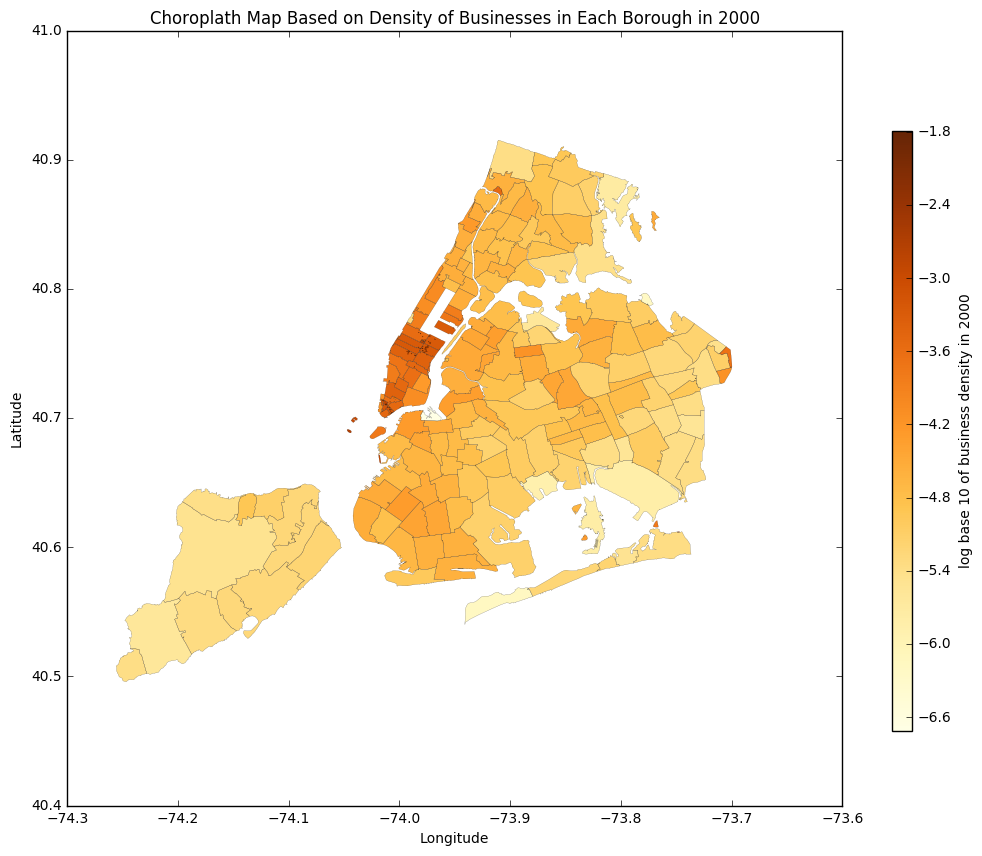

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
zip_x.plot(column='log10_BDensity',colormap='YlOrBr',alpha=1,linewidth=0.1,ax=ax,)
plt.title("Choroplath Map Based on Density of Businesses in Each Borough in 2000")
norm = mpl.colors.Normalize(vmin=zip_x['log10_BDensity'].min(),
                              vmax=zip_x['log10_BDensity'].max())
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax, cmap='YlOrBr', norm=norm, spacing='proportional')
cb.set_label('log base 10 of business density in 2000')

Fig 1. Choroplath Map Based on Density of Businesses in Each Borough in 2000. Although measured in log base 10, the 
dark portion on both map and color bar means greater vaules than the light ones, in terms of business density.

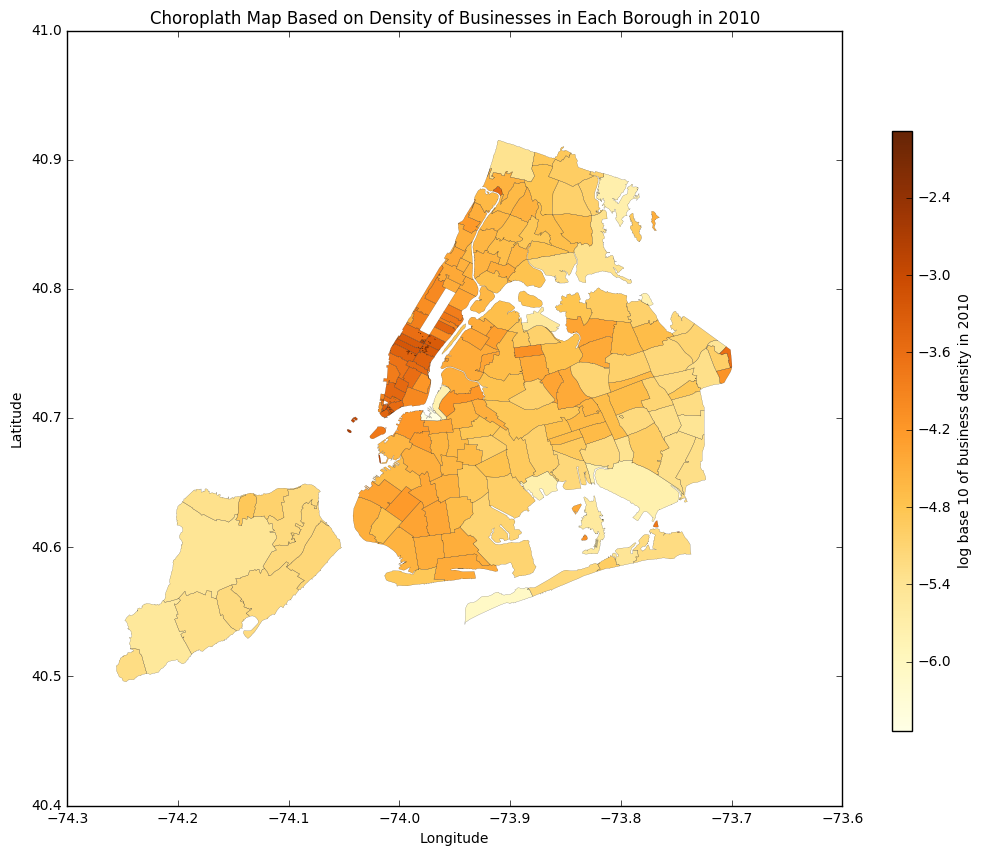

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
zip_y.plot(column='log10_BDensity',colormap='YlOrBr',alpha=1,linewidth=0.1,ax=ax,)
plt.title("Choroplath Map Based on Density of Businesses in Each Borough in 2010")
norm = mpl.colors.Normalize(vmin=zip_y['log10_BDensity'].min(),
                              vmax=zip_y['log10_BDensity'].max())
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax, cmap='YlOrBr', norm=norm, spacing='proportional')
cb.set_label('log base 10 of business density in 2010')

Fig 2. Choroplath Map Based on Density of Businesses in Each Borough in 2010. Although measured in log base 10, the 
dark portion on both map and color bar means greater vaules than the light ones, in terms of business density.

Plot a third choroplath map for comparsion between 2000 and 2010 maps

In [20]:
zip_z = zip_y.copy()
zip_z['Density_Change'] = zip_x['log10_BDensity'] - zip_y['log10_BDensity']
zip_z.head(2)

AREA BLDGZIP  COUNTY CTY_FIPS  POPULATION   PO_NAME  SHAPE_AREA  \
0  2.269930e+07       0  Queens      081     18681.0   Jamaica         0.0   
1  2.963100e+07       0   Kings      047     62426.0  Brooklyn         0.0   

   SHAPE_LEN STATE ST_FIPS                   URL    ZIP  \
0        0.0    NY      36  http://www.usps.com/  11436   
1        0.0    NY      36  http://www.usps.com/  11213   

                                            geometry  10EST  BDensity  \
0  POLYGON ((-73.80584847647394 40.68290932644246...     98  0.000004   
1  POLYGON ((-73.93739763139813 40.6797295892508,...    675  0.000023   

   log10_BDensity  Density_Change  
0       -5.364786       -0.178313  
1       -4.642443       -0.150785

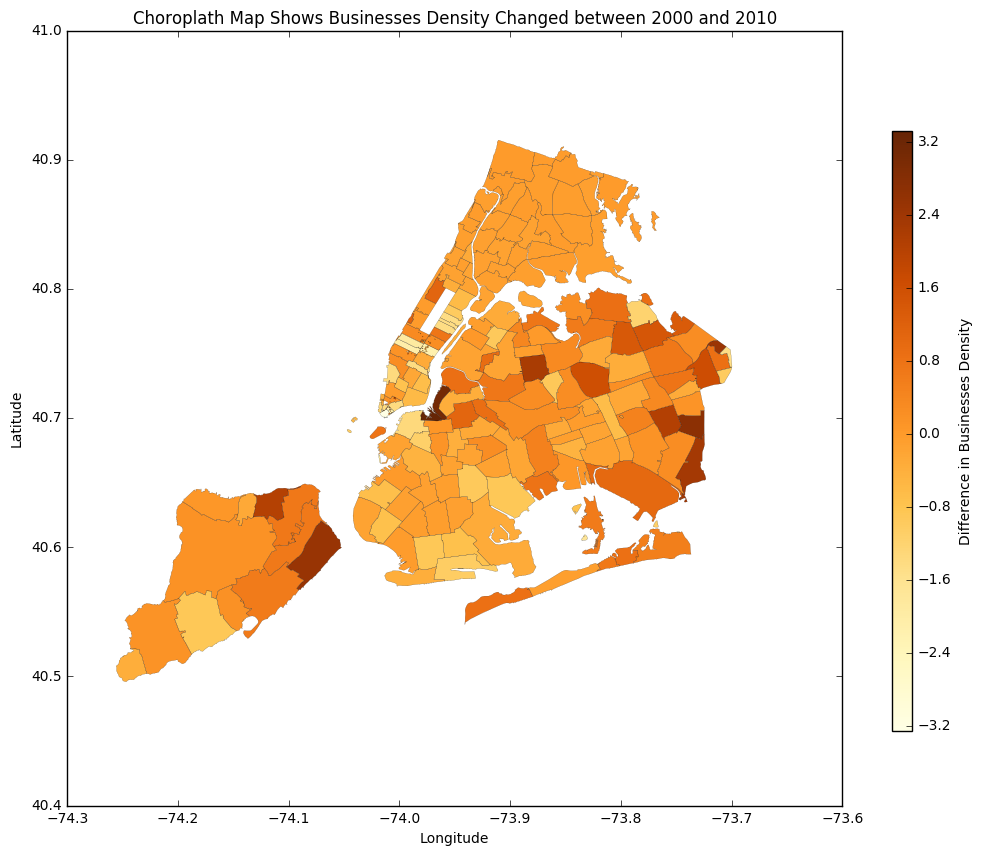

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
zip_z.plot(column='Density_Change',colormap='YlOrBr',alpha=1,linewidth=0.1,ax=ax,)
plt.title("Choroplath Map Shows Businesses Density Changed between 2000 and 2010")
norm = mpl.colors.Normalize(vmin=zip_z['Density_Change'].min(),
                              vmax=zip_z['Density_Change'].max())
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax, cmap='YlOrBr', norm=norm, spacing='proportional')
cb.set_label('Difference in Businesses Density')

Fig 3. Choroplath Map Shows Businesses Density Changed between 2000 and 2010. It shows the differnce in business density measured by log base 10, the darker the color is, the bigger the differnece is. 

### MORE SERIOUS STUFF

### 4. Collect census data from the 2010 and 2000 census and extract the estimate (mean or median) age, population, and diversity of each census tract for all 5 NYC boroughs. The diversity (or lack thereof) can be measured by the fraction of white population.

In [22]:
SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

Request and download 2000 Census Data

In [23]:
CensusQuery = '''SELECT geo_id,
                        hc01_vc01, 
                        hc01_vc18,
                        hc01_vc29
                  FROM DEC_00_SF1_DP1
               '''
CensusStream = queryCartoDB(CensusQuery, format='JSON')
CensusData = json.loads(CensusStream.read())
Census0 = pd.DataFrame.from_dict(CensusData['rows'])

In [24]:
Census0.rename(columns={'hc01_vc01' : 'total_population',
                        'hc01_vc18' : 'median_age',                              
                        'hc01_vc29' : 'num_white'}, inplace=True)

In [25]:
Census0['median_age'] = Census0['median_age'].astype(float)
Census0['num_white'] = Census0['num_white'].astype(float)
Census0['total_population'] = Census0['total_population'].astype(float)
Census0['percent_white'] = Census0['num_white'] / Census0['total_population']
Census0.head()

geo_id  total_population  median_age  num_white  \
0  1400000US36047054300               0.0         0.0        0.0   
1  1400000US36081121100               0.0         0.0        0.0   
2  1400000US36005003700             478.0        22.0       88.0   
3  1400000US36005004900             246.0        30.0       51.0   
4  1400000US36005005800               5.0        23.5        0.0   

   percent_white  
0            NaN  
1            NaN  
2       0.184100  
3       0.207317  
4       0.000000

Request and download 2010 Census Data

In [26]:
CensusQuery = '''SELECT geo_id,
                        hd01_s001, 
                        hd01_s020,
                        hd01_s078
                 FROM DEC_10_SF1_SF1DP1
               '''
CensusStream = queryCartoDB(CensusQuery, format='JSON')
CensusData = json.loads(CensusStream.read())
Census1 = pd.DataFrame.from_dict(CensusData['rows'])

In [27]:
Census1.rename(columns={'hd01_s001' : 'total_population',
                        'hd01_s020' : 'median_age',
                        'hd01_s078' : 'num_white'}, inplace=True)

In [28]:
Census1['median_age'] = Census1['median_age'].astype(float)
Census1['num_white'] = Census1['num_white'].astype(float)
Census1['total_population'] = Census1['total_population'].astype(float)
Census1['percent_white'] = Census1['num_white'] / Census1['total_population']
Census1.head()

geo_id  total_population  median_age  num_white  \
0  1400000US36081038301               0.0         0.0        0.0   
1  1400000US36005002400               4.0        38.0        2.0   
2  1400000US36059990200               0.0         0.0        0.0   
3  1400000US36059990400               0.0         0.0        0.0   
4  1400000US36007012900            1532.0        59.8     1504.0   

   percent_white  
0            NaN  
1       0.500000  
2            NaN  
3            NaN  
4       0.981723

In [29]:
# Both Census data contains entire NY state , i.e not only NYC

### 5. Collect the income data by census tract from the income from American Fact Finder for the years 2010 and 2000 at the census tract level.

Request and download 2000 Income Data

In [30]:
#https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?fpt=table

In [31]:
IncomeQuery = '''SELECT geo_id,
                        hc01_vc64
                 FROM DEC_00_SF3_DP3_with_ann
              '''
IncomeStream = queryCartoDB(IncomeQuery, format='CSV')
Income0 = pd.read_csv(IncomeStream)
Income0.rename(columns={'hc01_vc64' : 'median-income'}, inplace=True)
Income0['median-income'] = Income0['median-income'].astype(float)

In [32]:
Income0.head(2)

geo_id  median-income
0  1400000US36089991900            0.0
1  1400000US36001013703        68929.0

Request and download 2010 Income Data

In [33]:
#https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_10_5YR_S1901&prodType=table

In [34]:
IncomeQuery = '''SELECT geo_id,
                        hc01_est_vc13
                 FROM acs_10_5yr_s1901_with_ann
               '''
IncomeStream = queryCartoDB(IncomeQuery, format='CSV')
Income1 = pd.read_csv(IncomeStream)
Income1.rename(columns={'hc01_est_vc13' : 'median-income'}, inplace=True)
Income1['median-income']=Income1['median-income'].convert_objects(convert_numeric=True)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [35]:
Income1.head(2)

geo_id  median-income
0  1400000US36001000100        32333.0
1  1400000US36001000200        25354.0

In [36]:
# Both Income data contains entire NY state , i.e not only NYC

### 6. Merge the datasets for each year and show a the tables containing the relevant data: the features and whatever else you need to identify and plot the data.

Merge 2000 datasets

In [37]:
Data0 = Income0.merge(Census0, on='geo_id')
Data0.head(2)

geo_id  median-income  total_population  median_age  \
0  1400000US36089991900            0.0             988.0        20.4   
1  1400000US36001013703        68929.0            2975.0        41.6   

   num_white  percent_white  
0      917.0       0.928138  
1     2335.0       0.784874

Merge 2010 datasets

In [38]:
Data1 = Income1.merge(Census1, on='geo_id')
Data1.head(2)

geo_id  median-income  total_population  median_age  \
0  1400000US36001000100        32333.0            2139.0        32.2   
1  1400000US36001000200        25354.0            6046.0        28.8   

   num_white  percent_white  
0      506.0       0.236559  
1      840.0       0.138935

In [39]:
# Both Merged data contains entire NY state , i.e not only NYC

Select both data only within NYC region

In [40]:
Data0['ct_2010'] = Data0['geo_id'].str[11:]
Data0.head(2)

geo_id  median-income  total_population  median_age  \
0  1400000US36089991900            0.0             988.0        20.4   
1  1400000US36001013703        68929.0            2975.0        41.6   

   num_white  percent_white    ct_2010  
0      917.0       0.928138  089991900  
1     2335.0       0.784874  001013703

In [41]:
Data1['ct_2010'] = Data1['geo_id'].str[11:]
Data1.head(2)

geo_id  median-income  total_population  median_age  \
0  1400000US36001000100        32333.0            2139.0        32.2   
1  1400000US36001000200        25354.0            6046.0        28.8   

   num_white  percent_white    ct_2010  
0      506.0       0.236559  001000100  
1      840.0       0.138935  001000200

In [42]:
Data0_NYC = Data0[(Data0['ct_2010'].str[:3] == '061')|
                  (Data0['ct_2010'].str[:3] == '005')|
                  (Data0['ct_2010'].str[:3] == '085')|
                  (Data0['ct_2010'].str[:3] == '081')|
                  (Data0['ct_2010'].str[:3] == '047')]
Data0_NYC.head(2)

geo_id  median-income  total_population  median_age  \
2  1400000US36005000200        42539.0            3545.0        32.7   
3  1400000US36005002400            0.0               0.0         0.0   

   num_white  percent_white    ct_2010  
2     1136.0       0.320451  005000200  
3        0.0            NaN  005002400

In [43]:
Data1_NYC = Data1[(Data1['ct_2010'].str[:3] == '061')|
                  (Data1['ct_2010'].str[:3] == '005')|
                  (Data1['ct_2010'].str[:3] == '085')|
                  (Data1['ct_2010'].str[:3] == '081')|
                  (Data1['ct_2010'].str[:3] == '047')]
Data1_NYC.head(2)

geo_id  median-income  total_population  median_age  \
88  1400000US36005000100            NaN           11091.0        31.3   
89  1400000US36005000200        59826.0            4334.0        33.9   

    num_white  percent_white    ct_2010  
88     1724.0       0.155441  005000100  
89     1332.0       0.307337  005000200

### 7. Merge the df with the census tracts shapefile (see DATA and HINTS files) and display each of your features as a choropleth for both 2010 and 2000, and show the difference in the features as a third choroplath.

Request and Download census tracts shapefile

In [44]:
# http://cosmo.nyu.edu/~fb55/PUI2016/data/2010%20Census%20Tracts.geojson

In [45]:
Query = '''SELECT *
           FROM table_2010_census_tracts
        '''

Featurestream = queryCartoDB(Query, format='GeoJSON')
data  = json.loads(Featurestream.read())
M = gpd.GeoDataFrame.from_features(data['features'])

In [46]:
M.head(2)

boro_code boro_ct_2010 boro_name  cartodb_id cdeligibil ct_2010 ctlabel  \
0         3      3050804  Brooklyn         998          E  050804  508.04   
1         3      3027500  Brooklyn        1261          I  027500     275   

                                            geometry ntacode  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...    BK42   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...    BK35   

              ntaname  puma     shape_area     shape_leng  
0            Flatbush  4015  1110945.63082  4305.94762341  
1  Stuyvesant Heights  4003  1743574.56294  5390.78775209

In [47]:
# M data only contains NYC geometry

In [48]:
Feature = M[['boro_ct_2010','boro_name','geometry']]
Feature.head(2)

boro_ct_2010 boro_name                                           geometry
0      3050804  Brooklyn  (POLYGON ((-73.96140699999999 40.65217, -73.96...
1      3027500  Brooklyn  (POLYGON ((-73.935008 40.682764, -73.937932 40...

Give the 'geo_id' to each borough census tract 

In [49]:
countyID = {'Bronx':'005',
           'Manhattan':'061',
           'Staten Island':'085',
           'Brooklyn':'047',
           'Queens':'081'}

In [50]:
a = []
for i in range(len(Feature)):
    a.append('1400000US36' + countyID[Feature.boro_name[i]] + Feature.boro_ct_2010[i][1:])
    
Feature['geo_id'] = a
Feature['geo_id'] = Feature['geo_id'].convert_objects(convert_numeric=True)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [51]:
Feature.head()

boro_ct_2010 boro_name                                           geometry  \
0      3050804  Brooklyn  (POLYGON ((-73.96140699999999 40.65217, -73.96...   
1      3027500  Brooklyn  (POLYGON ((-73.935008 40.682764, -73.937932 40...   
2      2009200     Bronx  (POLYGON ((-73.847279 40.829315, -73.847320999...   
3      4099100    Queens  (POLYGON ((-73.791793 40.789352, -73.791563999...   
4      4000100    Queens  (POLYGON ((-73.949113 40.754524, -73.949144 40...   

                 geo_id  
0  1400000US36047050804  
1  1400000US36047027500  
2  1400000US36005009200  
3  1400000US36081099100  
4  1400000US36081000100

In [52]:
Data1_NYC.columns

Index([u'geo_id', u'median-income', u'total_population', u'median_age',
       u'num_white', u'percent_white', u'ct_2010'],
      dtype='object')

Merge 2000 census tracts shapefile with 2000 income data

In [53]:
Feature0 = Feature.merge(Data0_NYC, on='geo_id')
Feature0.head(2)

boro_ct_2010 boro_name                                           geometry  \
0      3027500  Brooklyn  (POLYGON ((-73.935008 40.682764, -73.937932 40...   
1      2009200     Bronx  (POLYGON ((-73.847279 40.829315, -73.847320999...   

                 geo_id  median-income  total_population  median_age  \
0  1400000US36047027500        30241.0            4171.0        33.9   
1  1400000US36005009200        36589.0            4877.0        31.7   

   num_white  percent_white    ct_2010  
0       61.0       0.014625  047027500  
1     1469.0       0.301210  005009200

Merge 2000 census tracts shapefile with 2000 income data

In [54]:
Feature1 = Feature.merge(Data1_NYC, on='geo_id')
Feature1.head(2)

boro_ct_2010 boro_name                                           geometry  \
0      3050804  Brooklyn  (POLYGON ((-73.96140699999999 40.65217, -73.96...   
1      3027500  Brooklyn  (POLYGON ((-73.935008 40.682764, -73.937932 40...   

                 geo_id  median-income  total_population  median_age  \
0  1400000US36047050804        40188.0            6250.0        32.7   
1  1400000US36047027500        52958.0            4180.0        35.6   

   num_white  percent_white    ct_2010  
0      969.0       0.155040  047050804  
1      380.0       0.090909  047027500

A third dataframe for comparisons

In [55]:
Feature2 = Feature1.copy()
Feature2['INCOME_Chnage'] = Feature0['median-income'] - Feature1['median-income']
Feature2['POP_Chnage'] = Feature0['total_population'] - Feature1['total_population']
Feature2['PW_Chnage'] = Feature0['percent_white'] - Feature1['percent_white']
Feature2['AGE_Chnage'] = Feature0['median_age'] - Feature1['median_age']
Feature2.head(2)

boro_ct_2010 boro_name                                           geometry  \
0      3050804  Brooklyn  (POLYGON ((-73.96140699999999 40.65217, -73.96...   
1      3027500  Brooklyn  (POLYGON ((-73.935008 40.682764, -73.937932 40...   

                 geo_id  median-income  total_population  median_age  \
0  1400000US36047050804        40188.0            6250.0        32.7   
1  1400000US36047027500        52958.0            4180.0        35.6   

   num_white  percent_white    ct_2010  INCOME_Chnage  POP_Chnage  PW_Chnage  \
0      969.0       0.155040  047050804        -9947.0     -2079.0  -0.140415   
1      380.0       0.090909  047027500       -16369.0       697.0   0.210301   

   AGE_Chnage  
0         1.2  
1        -3.9

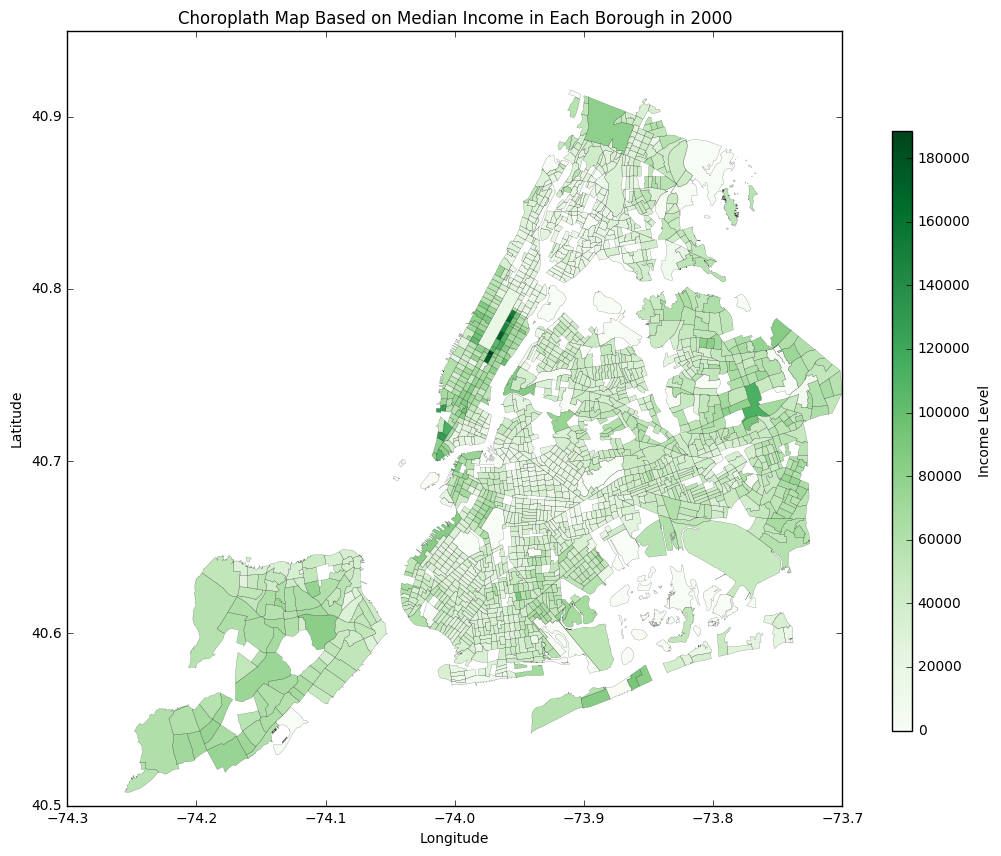

In [56]:
fig, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
Feature0.plot(column='median-income',colormap='Greens',alpha=1,linewidth=0.1,ax=ax,)
plt.title("Choroplath Map Based on Median Income in Each Borough in 2000")

norm = mpl.colors.Normalize(vmin=Feature0['median-income'].min(),
                              vmax=Feature0['median-income'].max())
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax, cmap='Greens', norm=norm, spacing='proportional')
cb.set_label('Income Level')

Fig 4. Choroplath Map Based on Median Income in Each Borough in 2000. The colors show the income variance. 

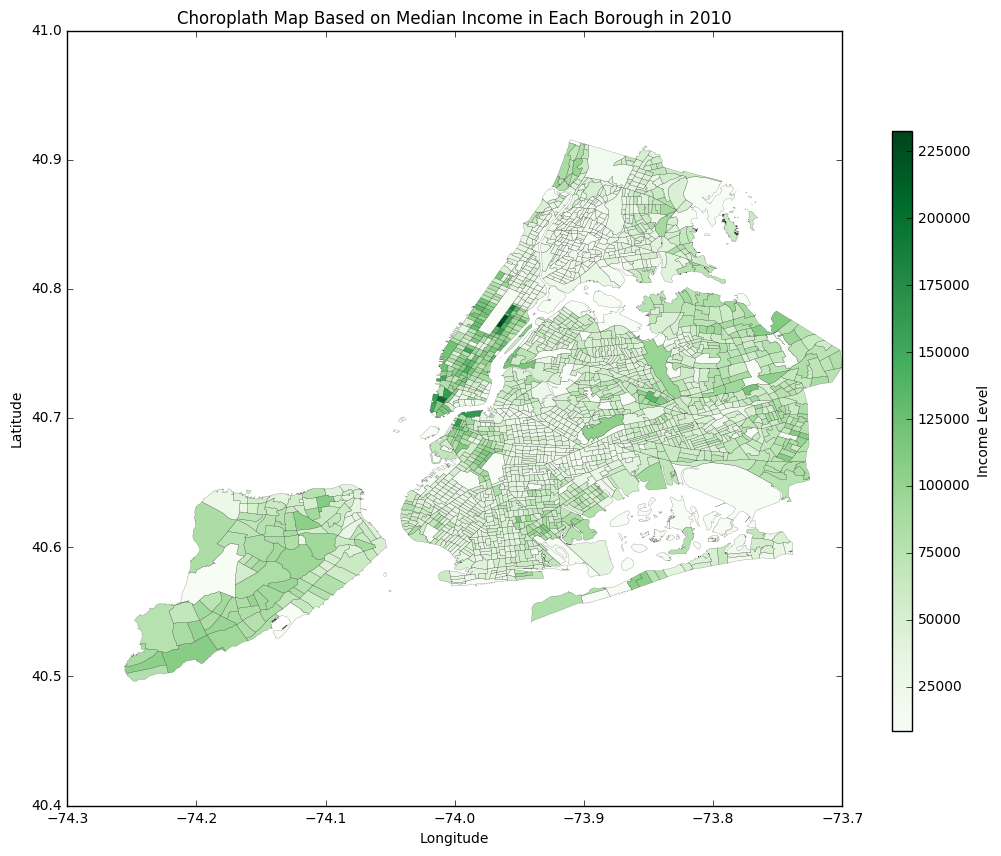

In [57]:
fig, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
Feature1.plot(column='median-income',colormap='Greens',alpha=1,linewidth=0.1,ax=ax,)
plt.title("Choroplath Map Based on Median Income in Each Borough in 2010")

norm = mpl.colors.Normalize(vmin=Feature1['median-income'].min(),
                              vmax=Feature1['median-income'].max())
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax, cmap='Greens', norm=norm, spacing='proportional')
cb.set_label('Income Level')

Fig 5. Choroplath Map Based on Median Income in Each Borough in 2010. The colors show the income variance. 

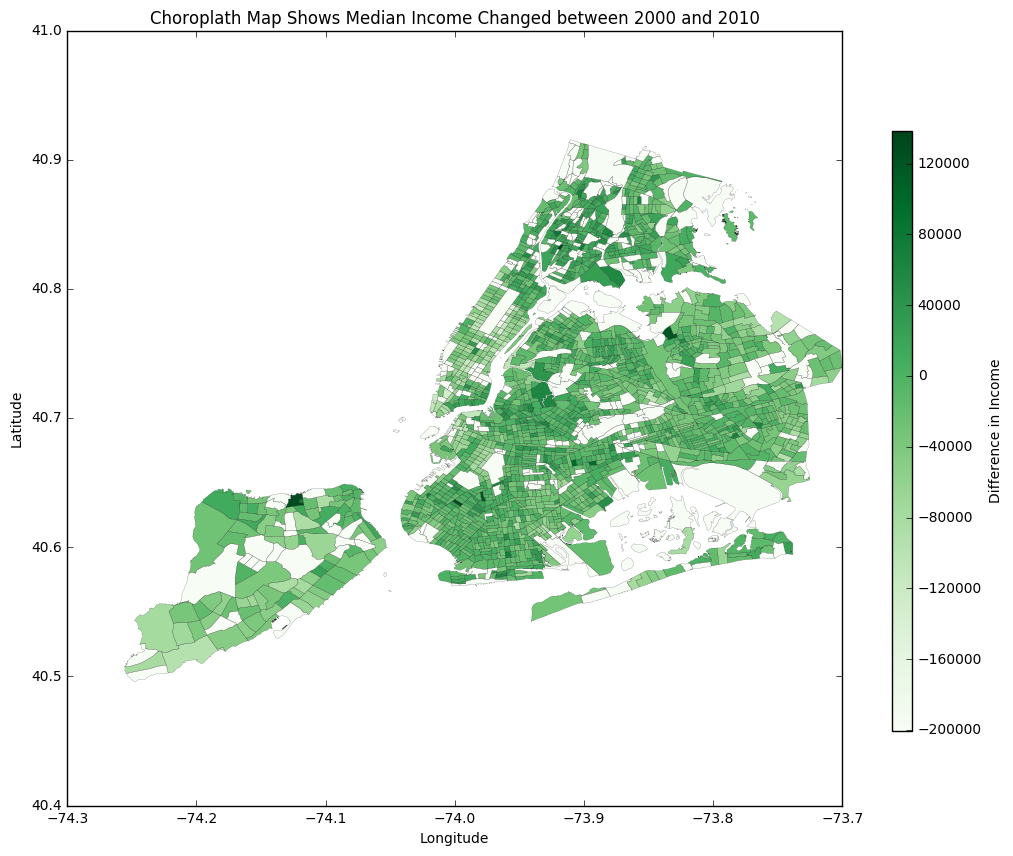

In [58]:
fig, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
Feature2.plot(column='INCOME_Chnage',colormap='Greens',alpha=1,linewidth=0.1,ax=ax,)
plt.title("Choroplath Map Shows Median Income Changed between 2000 and 2010")

norm = mpl.colors.Normalize(vmin=Feature2['INCOME_Chnage'].min(),
                              vmax=Feature2['INCOME_Chnage'].max())
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax, cmap='Greens', norm=norm, spacing='proportional')
cb.set_label('Difference in Income')

Fig 6. Choroplath Map Shows Median Income Changed between 2000 and 2010. The colors show the income variance between these two years. 

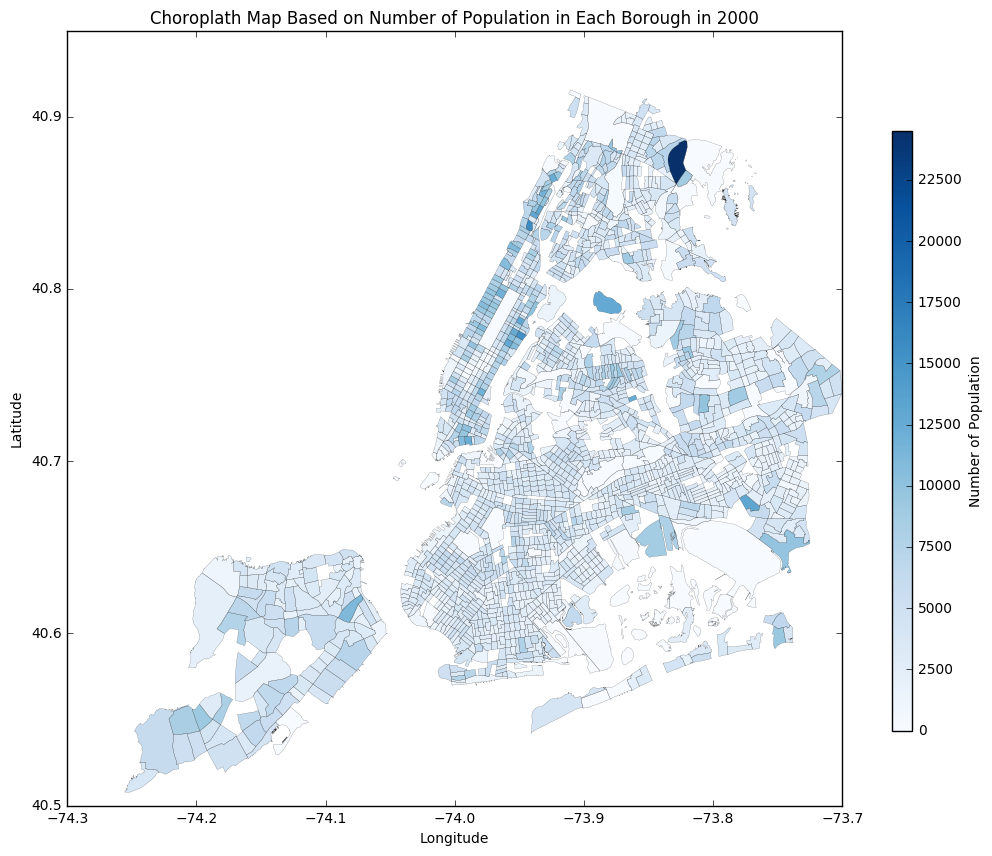

In [59]:
fig, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
Feature0.plot(column='total_population',colormap='Blues',alpha=1,linewidth=0.1,ax=ax,)
plt.title("Choroplath Map Based on Number of Population in Each Borough in 2000")

norm = mpl.colors.Normalize(vmin=Feature0['total_population'].min(),
                              vmax=Feature0['total_population'].max())
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax, cmap='Blues', norm=norm, spacing='proportional')
cb.set_label('Number of Population')

Fig 7. Choroplath Map Based on Number of Population in Each Borough in 2000. The colors show the population variance. 

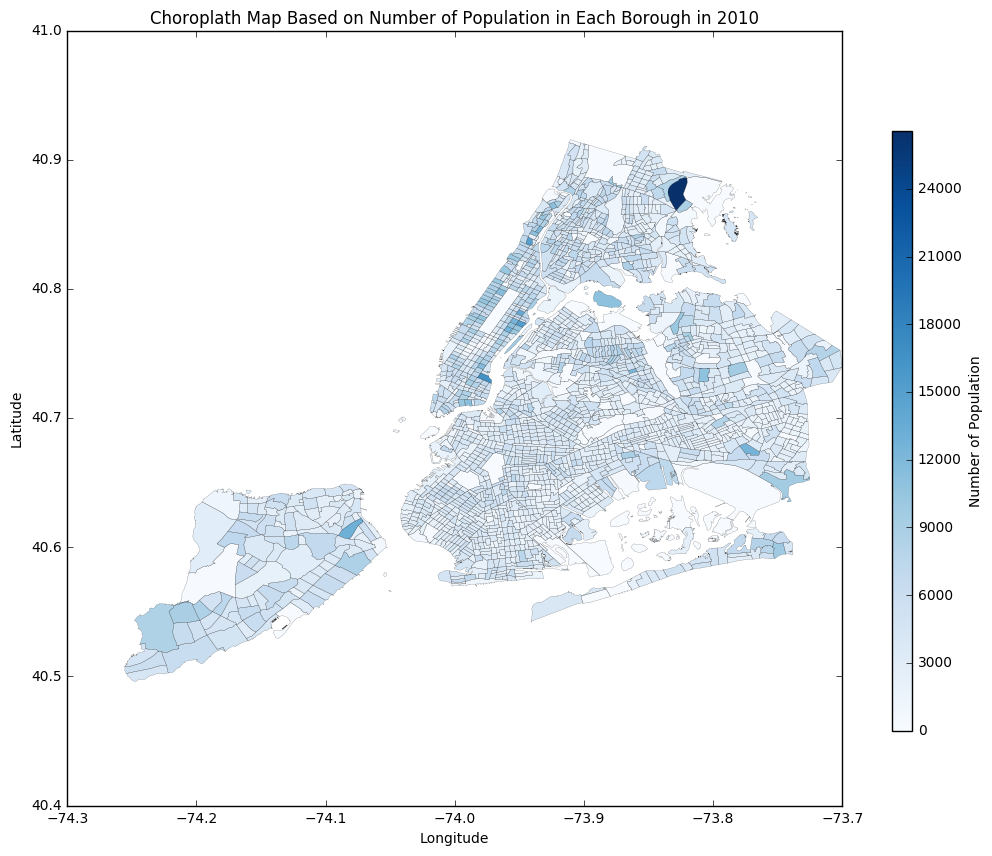

In [60]:
fig, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
Feature1.plot(column='total_population',colormap='Blues',alpha=1,linewidth=0.1,ax=ax,)
plt.title("Choroplath Map Based on Number of Population in Each Borough in 2010")

norm = mpl.colors.Normalize(vmin=Feature1['total_population'].min(),
                              vmax=Feature1['total_population'].max())
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax, cmap='Blues', norm=norm, spacing='proportional')
cb.set_label('Number of Population')

Fig 8. Choroplath Map Based on Number of Population in Each Borough in 2010. The colors show the population variance. 

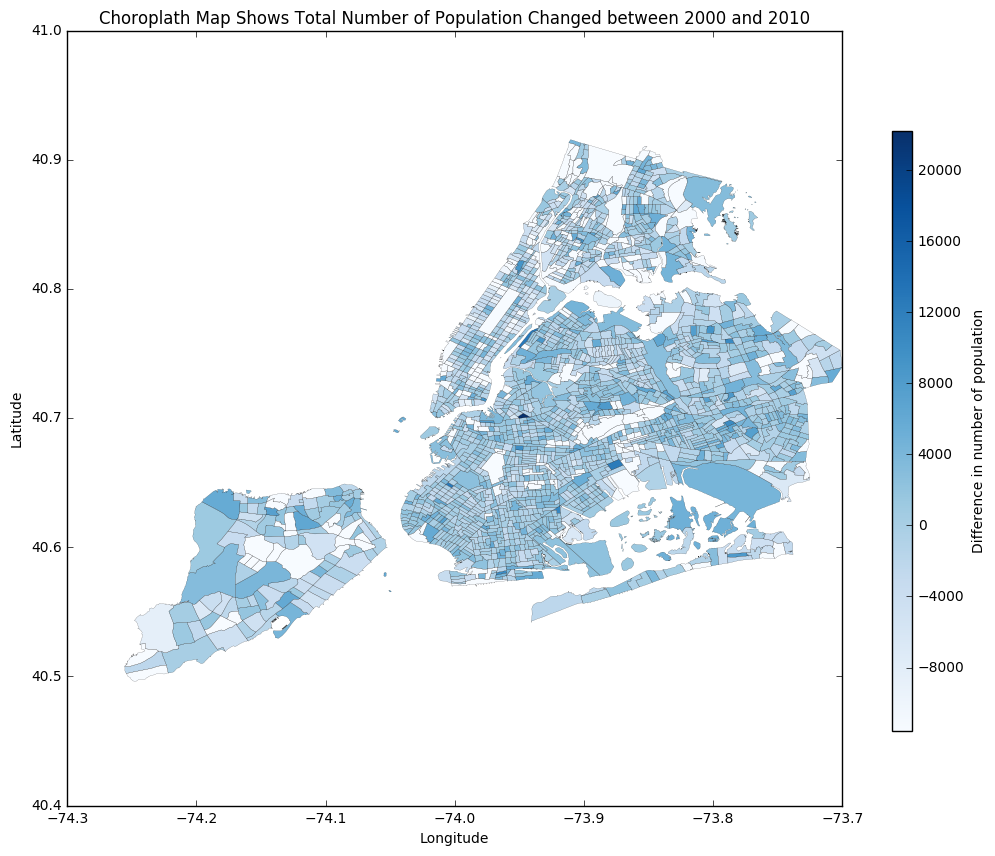

In [61]:
fig, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
Feature2.plot(column='POP_Chnage',colormap='Blues',alpha=1,linewidth=0.1,ax=ax,)
plt.title("Choroplath Map Shows Total Number of Population Changed between 2000 and 2010")

norm = mpl.colors.Normalize(vmin=Feature2['POP_Chnage'].min(),
                              vmax=Feature2['POP_Chnage'].max())
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax, cmap='Blues', norm=norm, spacing='proportional')
cb.set_label('Difference in number of population')

Fig 9. Choroplath Map Shows Total Number of Population Changed between 2000 and 2010. The colors show the population nember changed in each borough between these two years. 

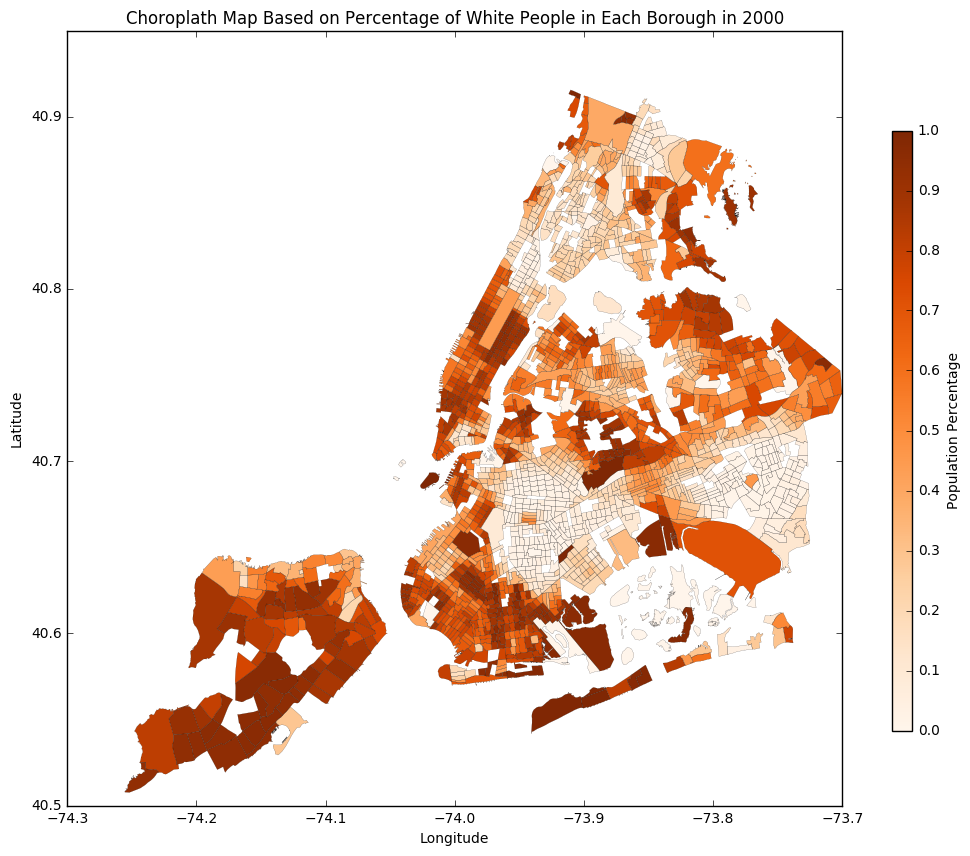

In [62]:
fig, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
Feature0.plot(column='percent_white',colormap='Oranges',alpha=1,linewidth=0.1,ax=ax,)
plt.title("Choroplath Map Based on Percentage of White People in Each Borough in 2000")

norm = mpl.colors.Normalize(vmin=Feature0['percent_white'].min(),
                              vmax=Feature0['percent_white'].max())
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax, cmap='Oranges', norm=norm, spacing='proportional')
cb.set_label('Population Percentage')

Fig 10. Choroplath Map Based on Percentage of White People in Each Borough in 2000. The colors show the percentage variance. 

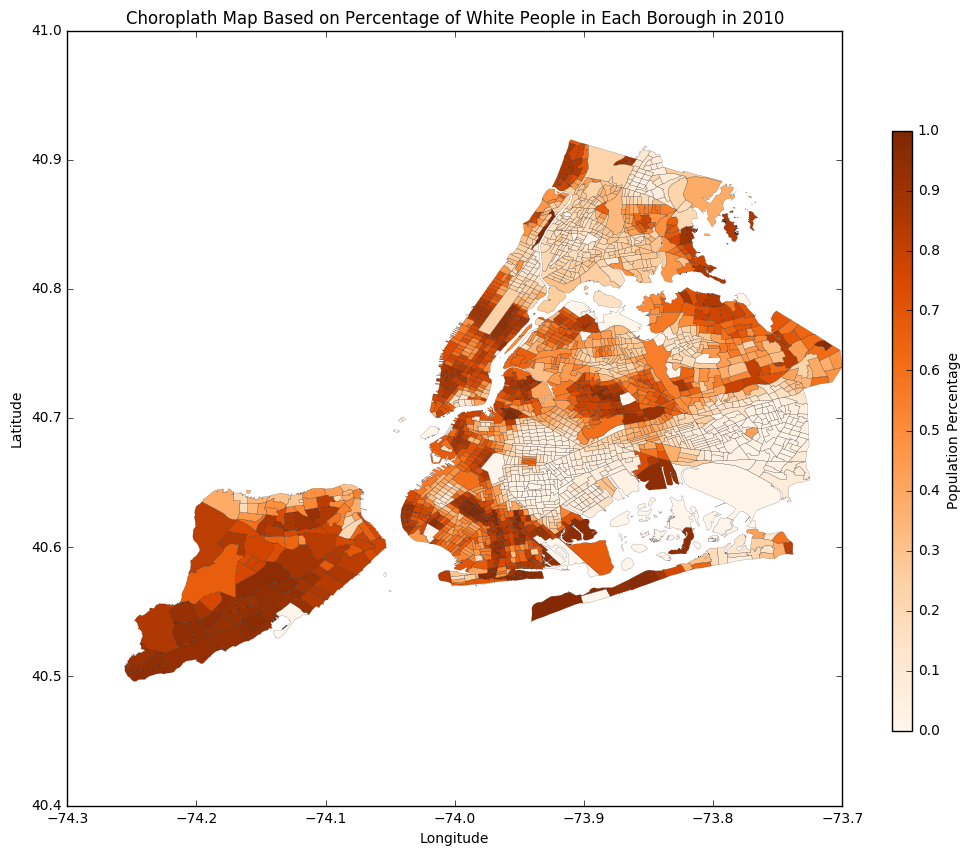

In [63]:
fig, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
Feature1.plot(column='percent_white',colormap='Oranges',alpha=1,linewidth=0.1,ax=ax,)
plt.title("Choroplath Map Based on Percentage of White People in Each Borough in 2010")

norm = mpl.colors.Normalize(vmin=Feature1['percent_white'].min(),
                              vmax=Feature1['percent_white'].max())
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax, cmap='Oranges', norm=norm, spacing='proportional')
cb.set_label('Population Percentage')

Fig 11. Choroplath Map Based on Percentage of White People in Each Borough in 2010. The colors show the percentage variance.

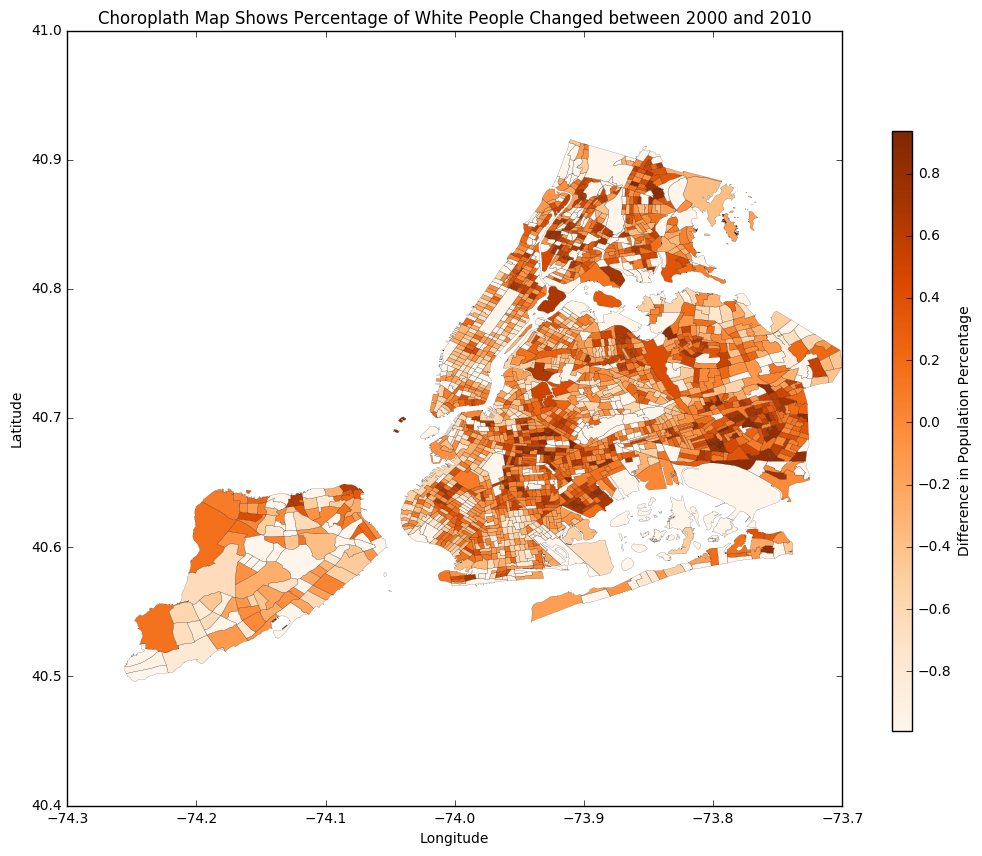

In [64]:
fig, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
Feature2.plot(column='PW_Chnage',colormap='Oranges',alpha=1,linewidth=0.1,ax=ax,)
plt.title("Choroplath Map Shows Percentage of White People Changed between 2000 and 2010")

norm = mpl.colors.Normalize(vmin=Feature2['PW_Chnage'].min(),
                              vmax=Feature2['PW_Chnage'].max())
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax, cmap='Oranges', norm=norm, spacing='proportional')
cb.set_label('Difference in Population Percentage')

Fig 12. Choroplath Map Shows Median Income Changed between 2000 and 2010. The colors show the income variance between these two years. 

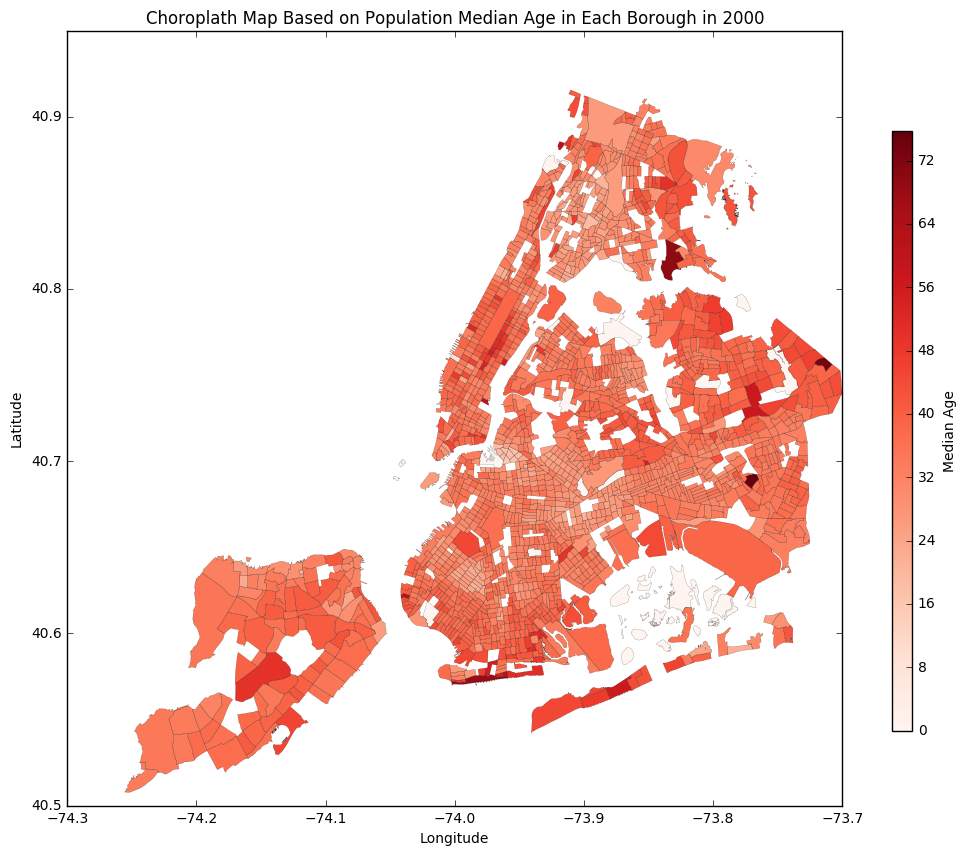

In [65]:
fig, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
Feature0.plot(column='median_age',colormap='Reds',alpha=1,linewidth=0.1,ax=ax,)
plt.title("Choroplath Map Based on Population Median Age in Each Borough in 2000")

norm = mpl.colors.Normalize(vmin=Feature0['median_age'].min(),
                              vmax=Feature0['median_age'].max())
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax, cmap='Reds', norm=norm, spacing='proportional')
cb.set_label('Median Age')

Fig 13. Choroplath Map Based on Population Median Age in Each Borough in 2000. The colors show the median age variance.

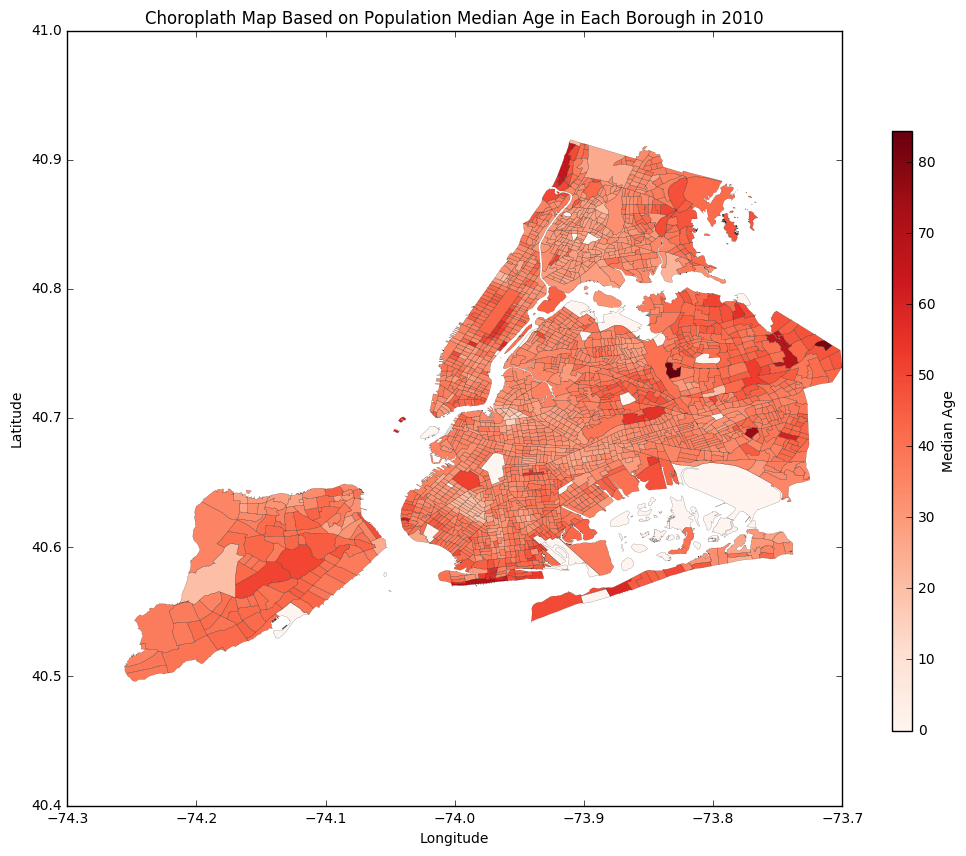

In [66]:
fig, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
Feature1.plot(column='median_age',colormap='Reds',alpha=1,linewidth=0.1,ax=ax,)
plt.title("Choroplath Map Based on Population Median Age in Each Borough in 2010")

norm = mpl.colors.Normalize(vmin=Feature1['median_age'].min(),
                              vmax=Feature1['median_age'].max())
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax, cmap='Reds', norm=norm, spacing='proportional')
cb.set_label('Median Age')

Fig 14. Choroplath Map Based on Population Median Age in Each Borough in 2010. The colors show the median age variance.

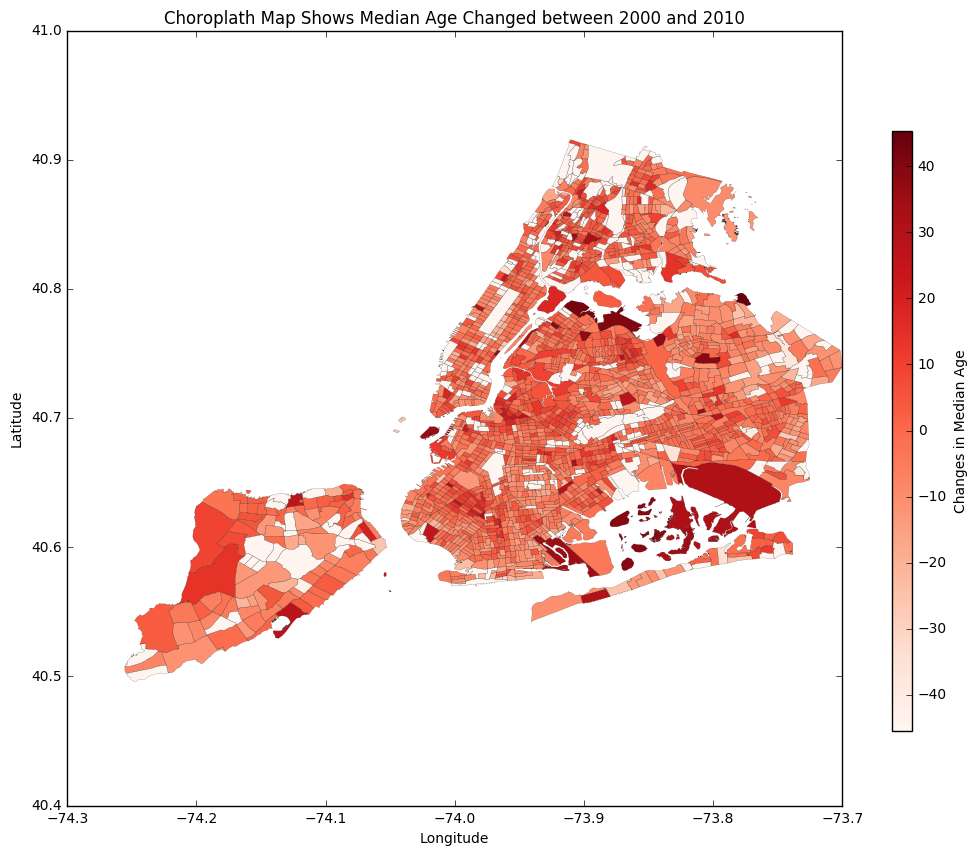

In [67]:
fig, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
Feature2.plot(column='AGE_Chnage',colormap='Reds',alpha=1,linewidth=0.1,ax=ax,)
plt.title("Choroplath Map Shows Median Age Changed between 2000 and 2010")

norm = mpl.colors.Normalize(vmin=Feature2['AGE_Chnage'].min(),
                              vmax=Feature2['AGE_Chnage'].max())
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax, cmap='Reds', norm=norm, spacing='proportional')
cb.set_label('Changes in Median Age')

Fig 15. Choroplath Map Shows Median Income Changed between 2000 and 2010. The colors show the income variance between these two years. 

### 8. (OPTIONAL) Cluster the census tracts on these four features (using a Eucledian distance)

In [68]:
#Feature0.isnull().sum()

In [69]:
A = Feature0.dropna()
Clustering0 = A[['median-income', 'total_population', 'median_age', 'percent_white']]

Use Average sillhoutte_score to determine how many clusters for 2000 census tract data

In [70]:
X = Clustering0 
range_n_clusters = [2,3,4,5,6,7,8,9]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.550009843964
For n_clusters =3, the average silhouette_score is :0.498114850696
For n_clusters =4, the average silhouette_score is :0.495424873535
For n_clusters =5, the average silhouette_score is :0.495757768295
For n_clusters =6, the average silhouette_score is :0.491504032699
For n_clusters =7, the average silhouette_score is :0.466131624234
For n_clusters =8, the average silhouette_score is :0.46523188725
For n_clusters =9, the average silhouette_score is :0.440282516168


Chooes two clusters according to the score result

In [71]:
agc = AgglomerativeClustering(n_clusters=2, compute_full_tree=True).fit(Clustering0)
labelsag = agc.labels_
A['labelsag']= labelsag

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


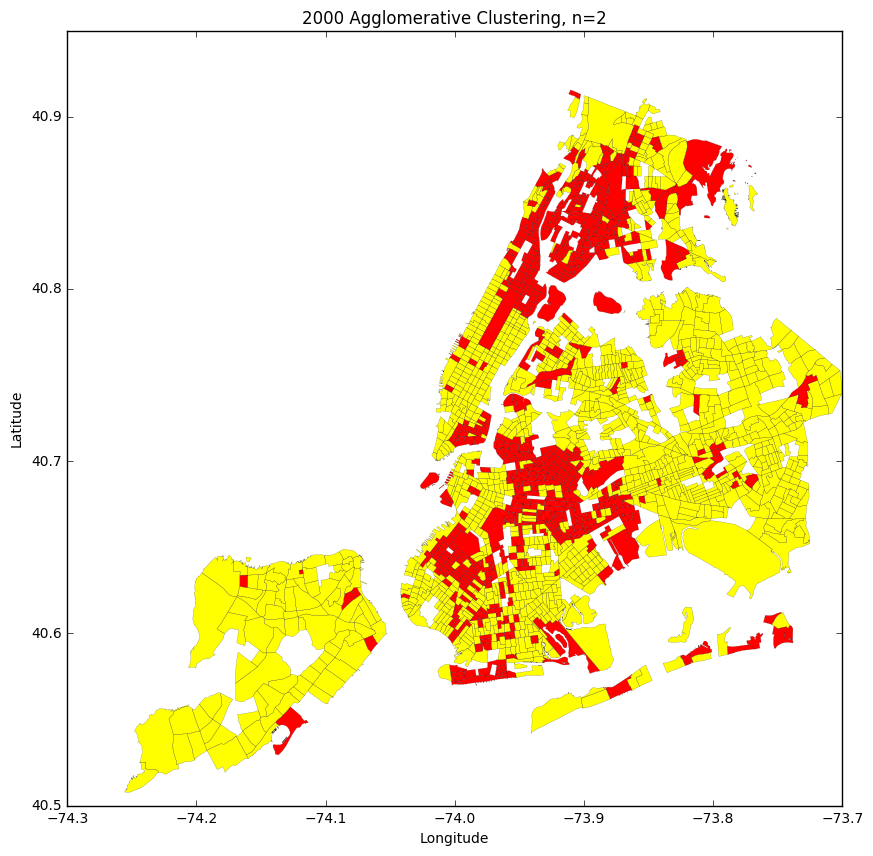

In [72]:
fig, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
A.plot(column='labelsag',cmap='autumn_r',categorical = True, alpha=1,linewidth=0.1,ax=ax,label= True)
plt.title("2000 Agglomerative Clustering, n=2")

Fig 16. Two clusters formed by Agglomerative Clustering in 2000, based on geo-id apporach.

Same method applied to 2010 census tract data

In [73]:
B = Feature1.dropna()
Clustering1 = B[['median-income', 'total_population', 'median_age', 'percent_white']]

In [74]:
X = Clustering1 
range_n_clusters = [2,3,4,5,6,7,8,9]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.575439976023
For n_clusters =3, the average silhouette_score is :0.526931428366
For n_clusters =4, the average silhouette_score is :0.524999910795
For n_clusters =5, the average silhouette_score is :0.496000164459
For n_clusters =6, the average silhouette_score is :0.503159784494
For n_clusters =7, the average silhouette_score is :0.498980445064
For n_clusters =8, the average silhouette_score is :0.487420358682
For n_clusters =9, the average silhouette_score is :0.478858389643


In [75]:
agc = AgglomerativeClustering(n_clusters=2, compute_full_tree=True).fit(Clustering1)
labelsag = agc.labels_
B['labelsag']= labelsag

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


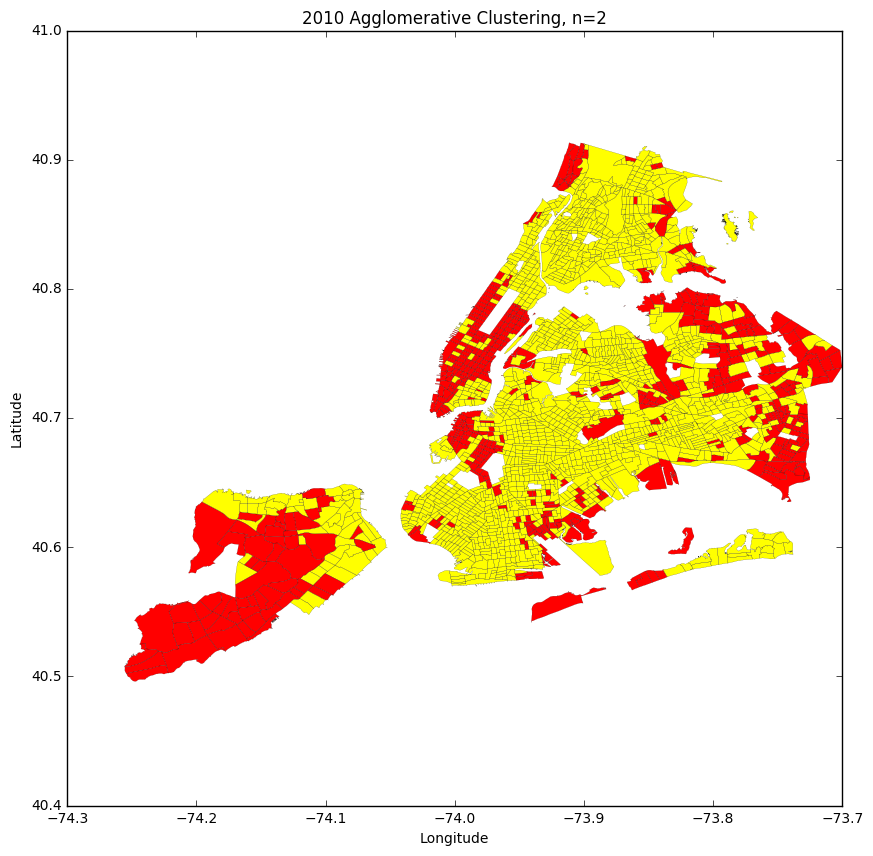

In [76]:
fig, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
B.plot(column='labelsag',cmap='autumn_r',categorical = True,alpha=1,linewidth=0.1,ax=ax,label= True)
plt.title("2010 Agglomerative Clustering, n=2")

Fig 17. Two clusters formed by Agglomerative Clustering in 2010, based on geo-id apporach.

### 9. (OPTIONAL) Identify the census tracts that have changed cluster assignment (those that are now associated with a different group of census tracts) and show a choropleth of the clusters in 2010, 2000 and a choropleth of the cluster changes. (Once you get through this, you have done most of the heavy lifting! The rest is building upon this work.)

In [77]:
A.head(2)

boro_ct_2010 boro_name                                           geometry  \
0      3027500  Brooklyn  (POLYGON ((-73.935008 40.682764, -73.937932 40...   
1      2009200     Bronx  (POLYGON ((-73.847279 40.829315, -73.847320999...   

                 geo_id  median-income  total_population  median_age  \
0  1400000US36047027500        30241.0            4171.0        33.9   
1  1400000US36005009200        36589.0            4877.0        31.7   

   num_white  percent_white    ct_2010  labelsag  
0       61.0       0.014625  047027500         1  
1     1469.0       0.301210  005009200         0

In [78]:
B.head(2)

boro_ct_2010 boro_name                                           geometry  \
0      3050804  Brooklyn  (POLYGON ((-73.96140699999999 40.65217, -73.96...   
1      3027500  Brooklyn  (POLYGON ((-73.935008 40.682764, -73.937932 40...   

                 geo_id  median-income  total_population  median_age  \
0  1400000US36047050804        40188.0            6250.0        32.7   
1  1400000US36047027500        52958.0            4180.0        35.6   

   num_white  percent_white    ct_2010  labelsag  
0      969.0       0.155040  047050804         0  
1      380.0       0.090909  047027500         0

In [79]:
B['compare'] = A.labelsag + B.labelsag == 1 # means '0 + 1' not the same, '0+0' and '1+1" are the same
B['compare2'] = [int(elem) for elem in B['compare']] # str converts to int

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [80]:
B.head(2)

boro_ct_2010 boro_name                                           geometry  \
0      3050804  Brooklyn  (POLYGON ((-73.96140699999999 40.65217, -73.96...   
1      3027500  Brooklyn  (POLYGON ((-73.935008 40.682764, -73.937932 40...   

                 geo_id  median-income  total_population  median_age  \
0  1400000US36047050804        40188.0            6250.0        32.7   
1  1400000US36047027500        52958.0            4180.0        35.6   

   num_white  percent_white    ct_2010  labelsag compare  compare2  
0      969.0       0.155040  047050804         0    True         1  
1      380.0       0.090909  047027500         0   False         0

A third map for comparision changes in clusterings between 2000 and 2010

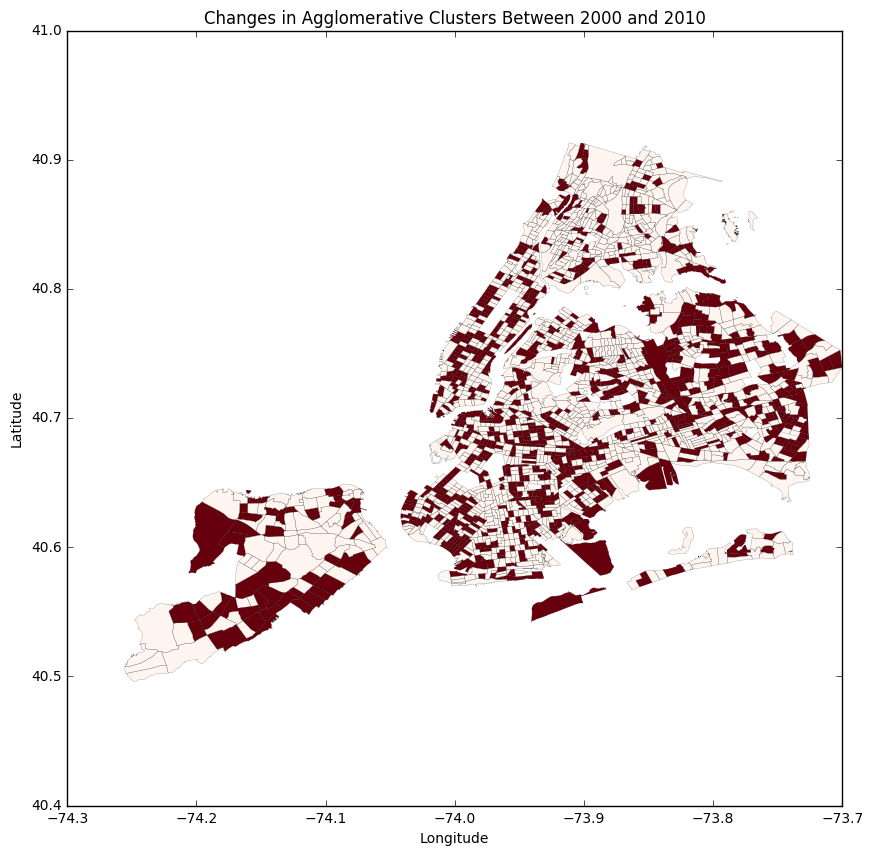

In [81]:
fig, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
B.plot(column ='compare2', cmap='Reds', categorical = True,alpha=1,linewidth=0.1, ax=ax, label= True)
plt.title("Changes in Agglomerative Clusters Between 2000 and 2010")

Fig 18. Changes in Agglomerative Clusters Between 2000 and 2010. Color shows where change occurs and how signficatant it is. Based on geo-id.

### 10. Aggregate the census four features at the zipcode level and merge the zipcode dataframe

Aggregate 2000 census four features at zipcode level 

In [82]:
b = []
for i in range(len(A)):
    if len(zip_x[([zip_x.geometry.contains(A.iloc[i].geometry)][0])].ZIP.values) > 0:
        b.append(zip_x[([zip_x.geometry.contains(A.iloc[i].geometry)][0])].ZIP.values[0])
    else: 
        b.append('NaN')

A['ZIP'] = b

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [83]:
A.head(2)

boro_ct_2010 boro_name                                           geometry  \
0      3027500  Brooklyn  (POLYGON ((-73.935008 40.682764, -73.937932 40...   
1      2009200     Bronx  (POLYGON ((-73.847279 40.829315, -73.847320999...   

                 geo_id  median-income  total_population  median_age  \
0  1400000US36047027500        30241.0            4171.0        33.9   
1  1400000US36005009200        36589.0            4877.0        31.7   

   num_white  percent_white    ct_2010  labelsag    ZIP  
0       61.0       0.014625  047027500         1    NaN  
1     1469.0       0.301210  005009200         0  10462

Aggregate 2010 census four features at zipcode level 

In [84]:
c = []
for i in range(len(B)):
    if len(zip_y[([zip_y.geometry.contains(B.iloc[i].geometry)][0])].ZIP.values) > 0:
        c.append(zip_y[([zip_y.geometry.contains(B.iloc[i].geometry)][0])].ZIP.values[0])
    else: 
        c.append('NaN')

B['ZIP'] = c

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [85]:
B.head(2)

boro_ct_2010 boro_name                                           geometry  \
0      3050804  Brooklyn  (POLYGON ((-73.96140699999999 40.65217, -73.96...   
1      3027500  Brooklyn  (POLYGON ((-73.935008 40.682764, -73.937932 40...   

                 geo_id  median-income  total_population  median_age  \
0  1400000US36047050804        40188.0            6250.0        32.7   
1  1400000US36047027500        52958.0            4180.0        35.6   

   num_white  percent_white    ct_2010  labelsag compare  compare2  ZIP  
0      969.0       0.155040  047050804         0    True         1  NaN  
1      380.0       0.090909  047027500         0   False         0  NaN

Merge 2000 census shapefile with income data

In [86]:
Agg0 = A.merge(zip_x, on='ZIP')
Agg0.head(2)

boro_ct_2010 boro_name                                         geometry_x  \
0      2009200     Bronx  (POLYGON ((-73.847279 40.829315, -73.847320999...   
1      2023000     Bronx  (POLYGON ((-73.8678 40.851589, -73.866805 40.8...   

                 geo_id  median-income  total_population  median_age  \
0  1400000US36005009200        36589.0            4877.0        31.7   
1  1400000US36005023000        26042.0            2754.0        30.5   

   num_white  percent_white    ct_2010       ...        PO_NAME SHAPE_AREA  \
0     1469.0       0.301210  005009200       ...          Bronx        0.0   
1     1103.0       0.400508  005023000       ...          Bronx        0.0   

   SHAPE_LEN STATE ST_FIPS                   URL  \
0        0.0    NY      36  http://www.usps.com/   
1        0.0    NY      36  http://www.usps.com/   

                                          geometry_y 00EST  BDensity  \
0  POLYGON ((-73.8705151214058 40.8569744976658, ...   954  0.000018   
1  POLYGON ((-73.8705151214058 40.8569744976658, ...   954  0.000018   

   log10_BDensity  
0       -4.744912  
1       -4.744912  

[2 rows x 27 columns]

Merge 2010 census shapefile with income data

In [87]:
Agg1 = B.merge(zip_y, on='ZIP')
Agg1.head(2)

boro_ct_2010 boro_name                                         geometry_x  \
0      2009200     Bronx  (POLYGON ((-73.847279 40.829315, -73.847320999...   
1      2022404     Bronx  (POLYGON ((-73.864814 40.854443, -73.86488 40....   

                 geo_id  median-income  total_population  median_age  \
0  1400000US36005009200        45625.0            5017.0        33.3   
1  1400000US36005022404        46988.0            4509.0        33.6   

   num_white  percent_white    ct_2010      ...        PO_NAME SHAPE_AREA  \
0     1478.0       0.294598  005009200      ...          Bronx        0.0   
1     1891.0       0.419383  005022404      ...          Bronx        0.0   

   SHAPE_LEN STATE  ST_FIPS                   URL  \
0        0.0    NY       36  http://www.usps.com/   
1        0.0    NY       36  http://www.usps.com/   

                                          geometry_y 10EST  BDensity  \
0  POLYGON ((-73.8705151214058 40.8569744976658, ...  1020  0.000019   
1  POLYGON ((-73.8705151214058 40.8569744976658, ...  1020  0.000019   

  log10_BDensity  
0       -4.71586  
1       -4.71586  

[2 rows x 29 columns]

Sort zip data for both 2000 and 2010

In [88]:
Agg0 = A[['median-income', 'total_population', 'median_age', 'percent_white','ZIP']]

In [89]:
Zip0 = Agg0.groupby(Agg0['ZIP']).mean().reset_index(level= 0)
Zip0.head(2)

ZIP  median-income  total_population  median_age  percent_white
0  10001   55284.000000            2312.0   37.800000       0.694058
1  10002   28029.333333            3149.0   41.166667       0.585239

In [90]:
Agg1 = B[['median-income', 'total_population', 'median_age', 'percent_white', 'ZIP']]

In [92]:
Zip1 = Agg1.groupby(Agg1['ZIP']).mean().reset_index(level= 0)
Zip1.head(2)

ZIP  median-income  total_population  median_age  percent_white
0  10001       77088.25       2859.500000   35.400000       0.632715
1  10002       57279.00       3061.333333   41.766667       0.609503

*** Find geo_id for ZIP (OPTIONAL)

In [ ]:
#Ziptest = Zip0.copy()

In [ ]:
#n = []
#for i in range(len(Ziptest)):
    #if len(Agg0[Ziptest.iloc[i].ZIP == Agg0['ZIP'].values].geo_id.values) > 0:
        #n.append(Agg0[Ziptest.iloc[i].ZIP == Agg0['ZIP'].values].geo_id.values[0])
    #else: 
        #n.append('NaN')    
    
#Ziptest['geo_id'] = n

In [ ]:
#Ziptest.head()

### 11. Repeat steps 7,8,9 at the zipcode level (NOT OPTIONAL AT THE ZIPCODE LEVEL) with the added feature (density of businesses).

In [93]:
Zip00 = zip_x.merge(Zip0, on='ZIP')
Zip00.head(2) 

AREA BLDGZIP  COUNTY CTY_FIPS  POPULATION   PO_NAME  SHAPE_AREA  \
0  2.269930e+07       0  Queens      081     18681.0   Jamaica         0.0   
1  2.963100e+07       0   Kings      047     62426.0  Brooklyn         0.0   

   SHAPE_LEN STATE ST_FIPS                   URL    ZIP  \
0        0.0    NY      36  http://www.usps.com/  11436   
1        0.0    NY      36  http://www.usps.com/  11213   

                                            geometry  00EST  BDensity  \
0  POLYGON ((-73.80584847647394 40.68290932644246...     65  0.000003   
1  POLYGON ((-73.93739763139813 40.6797295892508,...    477  0.000016   

   log10_BDensity  median-income  total_population  median_age  percent_white  
0       -5.543099       40679.25            1931.0        33.6       0.016051  
1       -4.793228       26238.20            4829.0        30.1       0.069132

In [94]:
Zip10 = zip_y.merge(Zip1, on='ZIP')
Zip10.head(2)

AREA BLDGZIP  COUNTY CTY_FIPS  POPULATION   PO_NAME  SHAPE_AREA  \
0  2.269930e+07       0  Queens      081     18681.0   Jamaica         0.0   
1  2.963100e+07       0   Kings      047     62426.0  Brooklyn         0.0   

   SHAPE_LEN STATE ST_FIPS                   URL    ZIP  \
0        0.0    NY      36  http://www.usps.com/  11436   
1        0.0    NY      36  http://www.usps.com/  11213   

                                            geometry  10EST  BDensity  \
0  POLYGON ((-73.80584847647394 40.68290932644246...     98  0.000004   
1  POLYGON ((-73.93739763139813 40.6797295892508,...    675  0.000023   

   log10_BDensity  median-income  total_population  median_age  percent_white  
0       -5.364786       62830.25           1918.75       34.20       0.039701  
1       -4.642443       33244.60           4617.80       32.86       0.096981

In [95]:
Zip2 = Zip10.copy()

In [96]:
Zip2['INCOME_Chnage'] = abs(Zip10['median-income'] - Zip00['median-income'])
Zip2['POP_Chnage'] = abs(Zip10['total_population'] - Zip00['total_population'])
Zip2['PW_Chnage'] = abs(Zip10['percent_white'] - Zip00['percent_white'])
Zip2['AGE_Chnage'] = abs(Zip10['median_age'] - Zip00['median_age'])
Zip2.head(2)

AREA BLDGZIP  COUNTY CTY_FIPS  POPULATION   PO_NAME  SHAPE_AREA  \
0  2.269930e+07       0  Queens      081     18681.0   Jamaica         0.0   
1  2.963100e+07       0   Kings      047     62426.0  Brooklyn         0.0   

   SHAPE_LEN STATE ST_FIPS     ...      BDensity  log10_BDensity  \
0        0.0    NY      36     ...      0.000004       -5.364786   
1        0.0    NY      36     ...      0.000023       -4.642443   

  median-income  total_population  median_age  percent_white  INCOME_Chnage  \
0      62830.25           1918.75       34.20       0.039701        22151.0   
1      33244.60           4617.80       32.86       0.096981         7006.4   

   POP_Chnage  PW_Chnage  AGE_Chnage  
0       12.25   0.023650        0.60  
1      211.20   0.027849        2.76  

[2 rows x 24 columns]

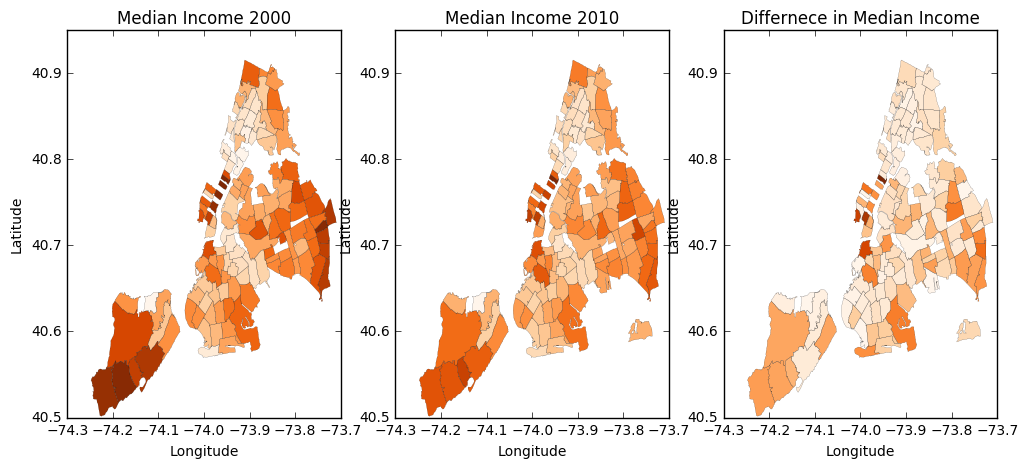

In [97]:
fig,ax = plt.subplots(figsize=(12,5))

ax1 = plt.subplot(131)
ax1.get_xaxis().set_visible(True)
ax1.get_yaxis().set_visible(True)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
Zip00.plot(column = 'median-income',colormap='Oranges',alpha=1,linewidth = 0.1,ax = ax1)
plt.title("Median Income 2000")


ax2 = plt.subplot(132)
ax2.get_xaxis().set_visible(True)
ax2.get_yaxis().set_visible(True)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
Zip10.plot(column = 'median-income',colormap='Oranges',alpha=1,linewidth = 0.1,ax = ax2)
plt.title("Median Income 2010")


ax3 = plt.subplot(133)
ax3.get_xaxis().set_visible(True)
ax3.get_yaxis().set_visible(True)
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
Zip2.plot(column = 'INCOME_Chnage',colormap='Oranges',alpha=1,linewidth = 0.1,ax = ax3)
plt.title("Differnece in Median Income")


Fig 19. On zipcode level shows how NYC citizens 'Median Income' changes between 2000 and 2010.

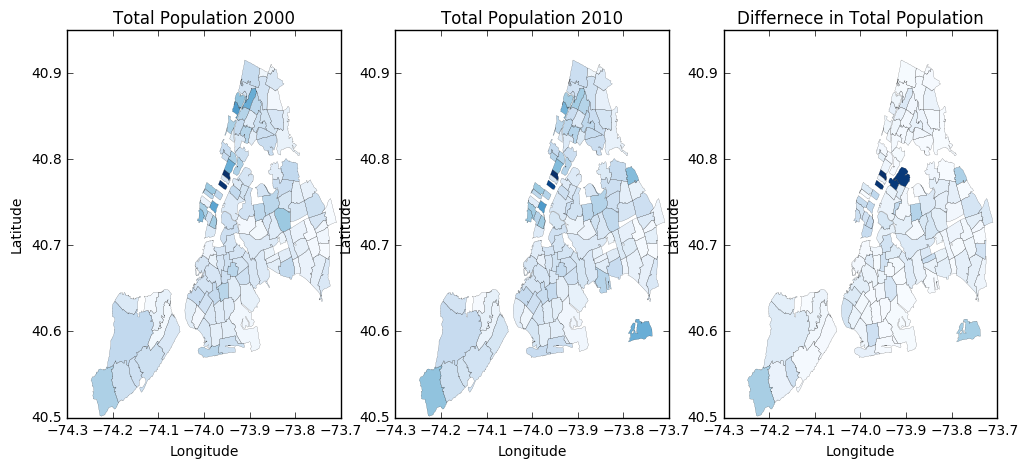

In [98]:
fig,ax = plt.subplots(figsize=(12,5))

ax1 = plt.subplot(131)
ax1.get_xaxis().set_visible(True)
ax1.get_yaxis().set_visible(True)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
Zip00.plot(column = 'total_population',colormap='Blues',alpha=1,linewidth = 0.1,ax = ax1)
plt.title("Total Population 2000")


ax2 = plt.subplot(132)
ax2.get_xaxis().set_visible(True)
ax2.get_yaxis().set_visible(True)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
Zip10.plot(column = 'total_population',colormap='Blues',alpha=1,linewidth = 0.1,ax = ax2)
plt.title("Total Population 2010")


ax3 = plt.subplot(133)
ax3.get_xaxis().set_visible(True)
ax3.get_yaxis().set_visible(True)
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
Zip2.plot(column = 'POP_Chnage',colormap='Blues',alpha=1,linewidth = 0.1,ax = ax3)
plt.title("Differnece in Total Population")


Fig 20. On zipcode level shows how NYC population changed in five boroughs between 2000 and 2010.

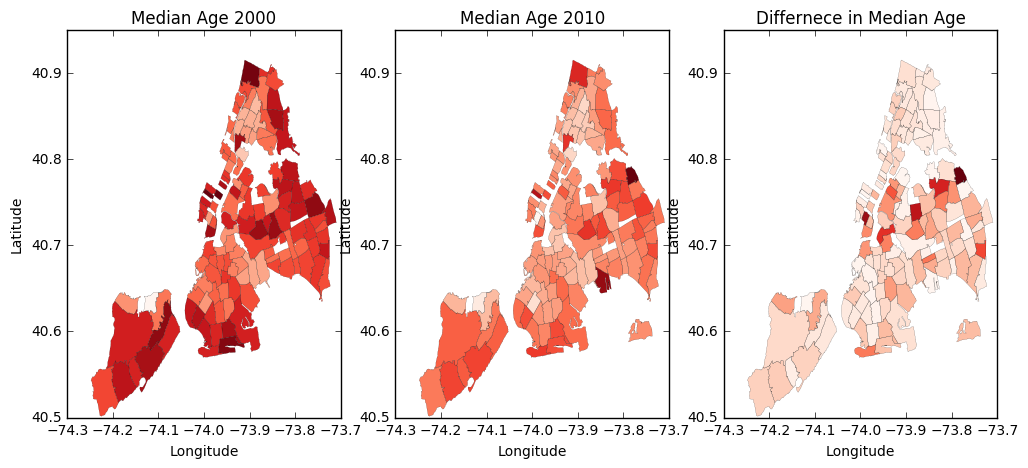

In [99]:
fig,ax = plt.subplots(figsize=(12,5))

ax1 = plt.subplot(131)
ax1.get_xaxis().set_visible(True)
ax1.get_yaxis().set_visible(True)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
Zip00.plot(column = 'median_age',colormap='Reds',alpha=1,linewidth = 0.1,ax = ax1)
plt.title("Median Age 2000")


ax2 = plt.subplot(132)
ax2.get_xaxis().set_visible(True)
ax2.get_yaxis().set_visible(True)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
Zip10.plot(column = 'median_age',colormap='Reds',alpha=1,linewidth = 0.1,ax = ax2)
plt.title("Median Age 2010")


ax3 = plt.subplot(133)
ax3.get_xaxis().set_visible(True)
ax3.get_yaxis().set_visible(True)
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
Zip2.plot(column = 'AGE_Chnage',colormap='Reds',alpha=1,linewidth = 0.1,ax = ax3)
plt.title("Differnece in Median Age")


Fig 21. On zipcode level shows how NYC citizens 'Median Age' changes between 2000 and 2010.

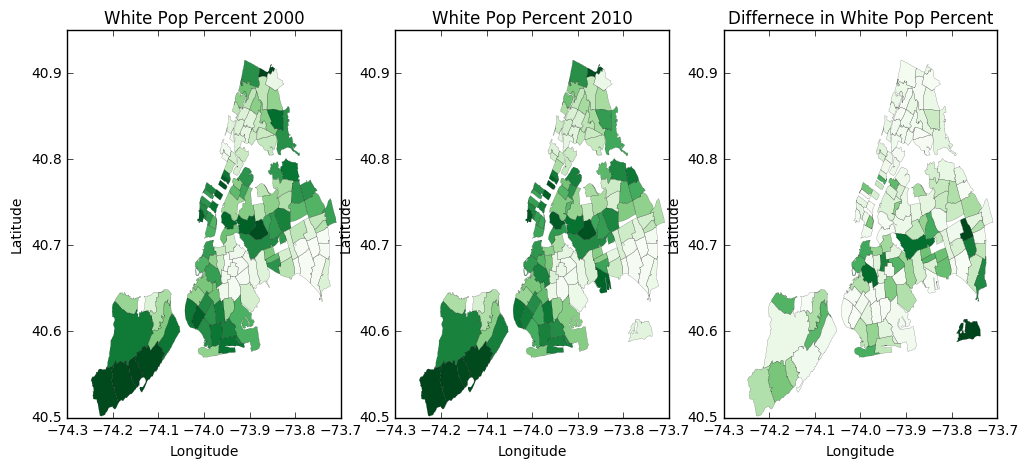

In [100]:
fig,ax = plt.subplots(figsize=(12,5))

ax1 = plt.subplot(131)
ax1.get_xaxis().set_visible(True)
ax1.get_yaxis().set_visible(True)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
Zip00.plot(column = 'percent_white',colormap='Greens',alpha=1,linewidth = 0.1,ax = ax1)
plt.title("White Pop Percent 2000")


ax2 = plt.subplot(132)
ax2.get_xaxis().set_visible(True)
ax2.get_yaxis().set_visible(True)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
Zip10.plot(column = 'percent_white',colormap='Greens',alpha=1,linewidth = 0.1,ax = ax2)
plt.title("White Pop Percent 2010")


ax3 = plt.subplot(133)
ax3.get_xaxis().set_visible(True)
ax3.get_yaxis().set_visible(True)
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
Zip2.plot(column = 'PW_Chnage',colormap='Greens',alpha=1,linewidth = 0.1,ax = ax3)
plt.title("Differnece in White Pop Percent")


Fig 22. On zipcode level shows how white people percentage changed in five boroughs between 2000 and 2010.

In [101]:
W = Zip00.dropna()
ZIPC0 = W[['median-income', 'total_population', 'median_age', 'percent_white']]

In [102]:
X = ZIPC0
range_n_clusters = [2,3,4,5,6,7,8,9]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.540011479088
For n_clusters =3, the average silhouette_score is :0.544560980306
For n_clusters =4, the average silhouette_score is :0.548139701806
For n_clusters =5, the average silhouette_score is :0.52066971705
For n_clusters =6, the average silhouette_score is :0.514338152512
For n_clusters =7, the average silhouette_score is :0.491364814512
For n_clusters =8, the average silhouette_score is :0.4953177491
For n_clusters =9, the average silhouette_score is :0.486272519325


In [103]:
ZIPC0.head()

median-income  total_population  median_age  percent_white
0   40679.250000       1931.000000   33.600000       0.016051
1   26238.200000       4829.000000   30.100000       0.069132
2   25987.666667       3878.833333   27.716667       0.030972
3   42225.000000       3927.000000   35.500000       0.068500
4   31159.714286       4435.714286   32.314286       0.509342

In [104]:
agc = AgglomerativeClustering(n_clusters=2, compute_full_tree=True).fit(ZIPC0)
labelsag = agc.labels_
W['labelsag']= labelsag

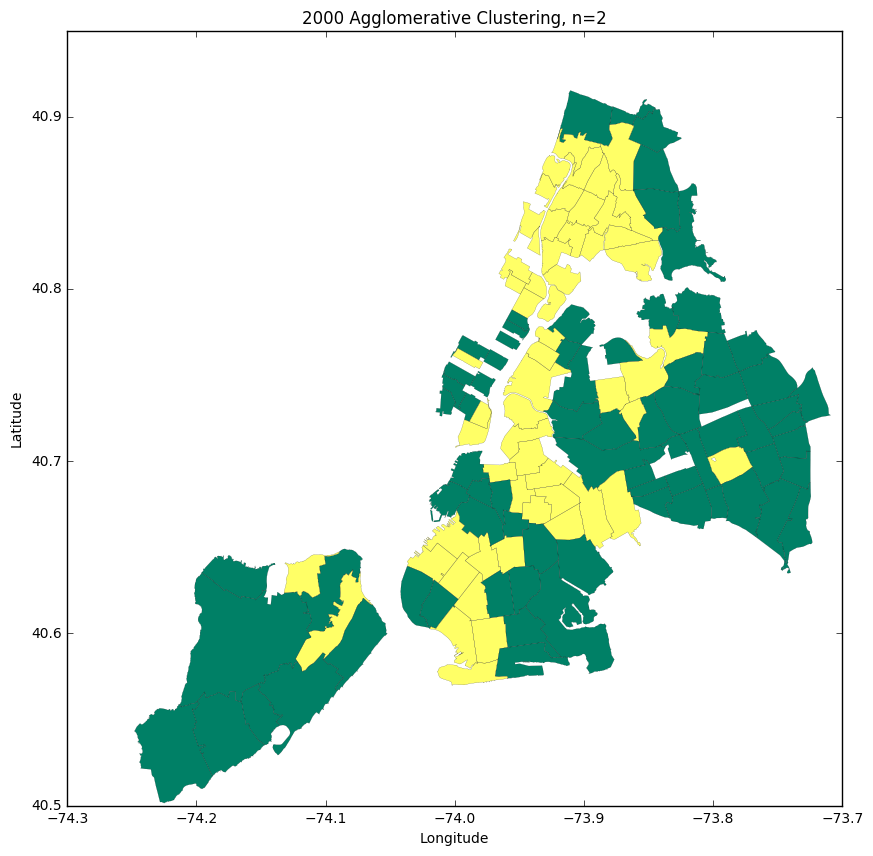

In [105]:
fig, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
W.plot(column='labelsag',cmap='summer',alpha=1,categorical = True,linewidth=0.1,ax=ax,label= True)
plt.title("2000 Agglomerative Clustering, n=2")

Fig 23. Two clusters formed by Agglomerative Clustering in 2000 based on zipcode.

In [112]:
Q = Zip10.dropna()
ZIPC1 = Q[['median-income', 'total_population', 'median_age', 'percent_white']]

In [113]:
X = ZIPC1
range_n_clusters = [2,3,4,5,6,7,8,9]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.566185975469
For n_clusters =3, the average silhouette_score is :0.550059475306
For n_clusters =4, the average silhouette_score is :0.534279464081
For n_clusters =5, the average silhouette_score is :0.512883337364
For n_clusters =6, the average silhouette_score is :0.51072256737
For n_clusters =7, the average silhouette_score is :0.543559333339
For n_clusters =8, the average silhouette_score is :0.547835897609
For n_clusters =9, the average silhouette_score is :0.531186719891


In [114]:
agc = AgglomerativeClustering(n_clusters=2, compute_full_tree=True).fit(ZIPC1)
labelsag = agc.labels_
Q['labelsag']= labelsag

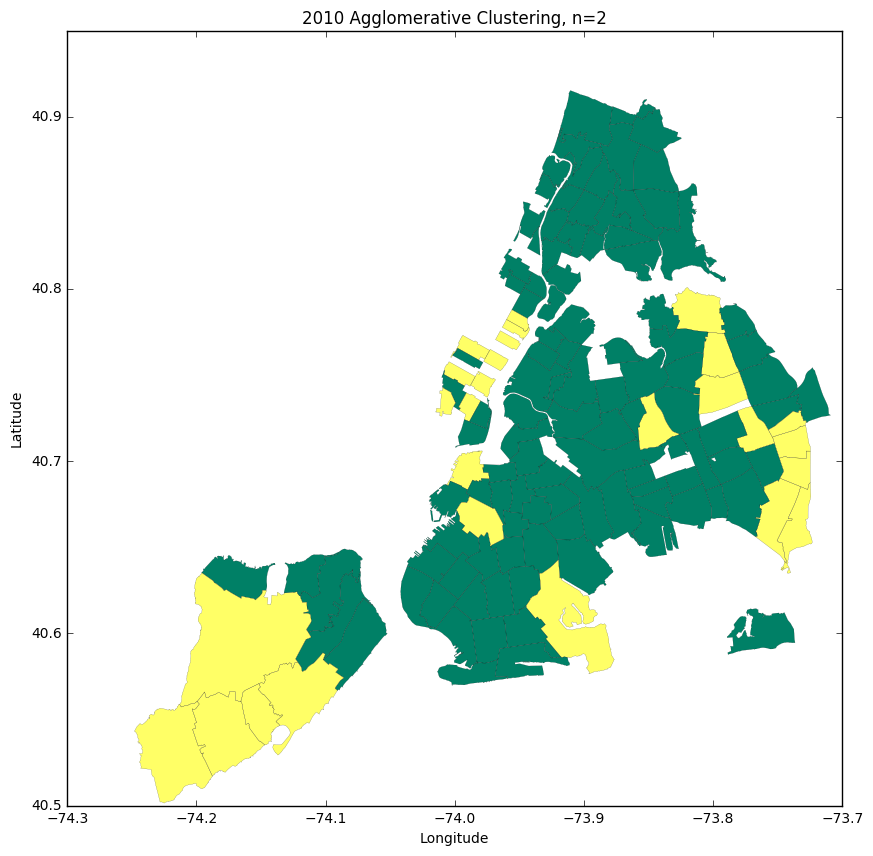

In [115]:
fig, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
Q.plot(column='labelsag',cmap='summer',categorical = True, alpha=1,linewidth=0.1,ax=ax,label= True)
plt.title("2010 Agglomerative Clustering, n=2")

Fig 24. Two clusters formed by Agglomerative Clustering in 2010 based on zipcode.

In [116]:
clustering_test = Q.copy()

In [117]:
clustering_test['compare'] = W.labelsag + Q.labelsag == 1 # means '0 + 1' not the same, '0+0' and '1+1" are the same

In [118]:
clustering_test['compare2'] = [int(elem) for elem in clustering_test['compare']] # str converts to int

In [119]:
clustering_test.head()

AREA BLDGZIP  COUNTY CTY_FIPS  POPULATION   PO_NAME  SHAPE_AREA  \
0  2.269930e+07       0  Queens      081     18681.0   Jamaica         0.0   
1  2.963100e+07       0   Kings      047     62426.0  Brooklyn         0.0   
2  4.197210e+07       0   Kings      047     83866.0  Brooklyn         0.0   
3  2.369863e+07       0   Kings      047     56527.0  Brooklyn         0.0   
4  3.686880e+07       0   Kings      047     72280.0  Brooklyn         0.0   

   SHAPE_LEN STATE ST_FIPS    ...    10EST  BDensity log10_BDensity  \
0        0.0    NY      36    ...       98  0.000004      -5.364786   
1        0.0    NY      36    ...      675  0.000023      -4.642443   
2        0.0    NY      36    ...      699  0.000017      -4.778484   
3        0.0    NY      36    ...      580  0.000024      -4.611295   
4        0.0    NY      36    ...     1474  0.000040      -4.398162   

   median-income  total_population  median_age  percent_white  labelsag  \
0   62830.250000       1918.750000   34.200000       0.039701         0   
1   33244.600000       4617.800000   32.860000       0.096981         0   
2   33045.666667       3834.666667   31.150000       0.052002         0   
3   45291.000000       3262.000000   39.150000       0.170938         0   
4   41823.428571       4354.857143   32.457143       0.515541         0   

   compare  compare2  
0    False         0  
1     True         1  
2     True         1  
3    False         0  
4     True         1  

[5 rows x 23 columns]

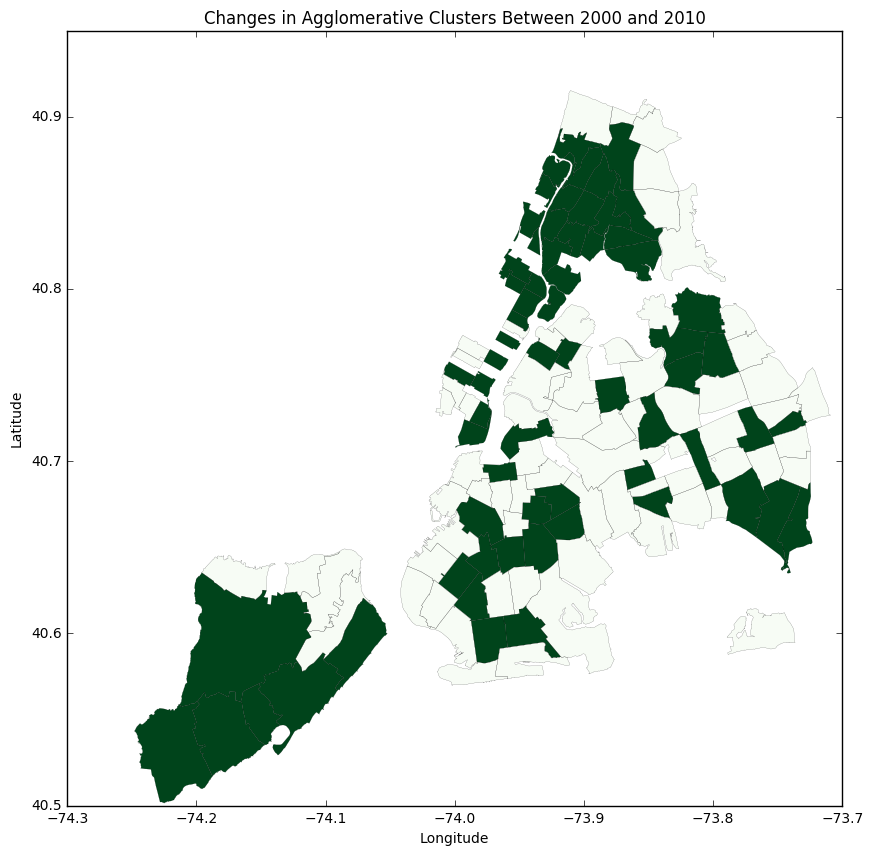

In [120]:
fig, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
clustering_test.plot(column ='compare2',cmap='Greens',categorical = True,alpha=1,linewidth=0.1,ax=ax,label= True)
plt.title("Changes in Agglomerative Clusters Between 2000 and 2010")

Fig 26. Changes in Agglomerative Clusters Between 2000 and 2010. Color shows where change occurs and how signficatant it is. Based on zipcode.

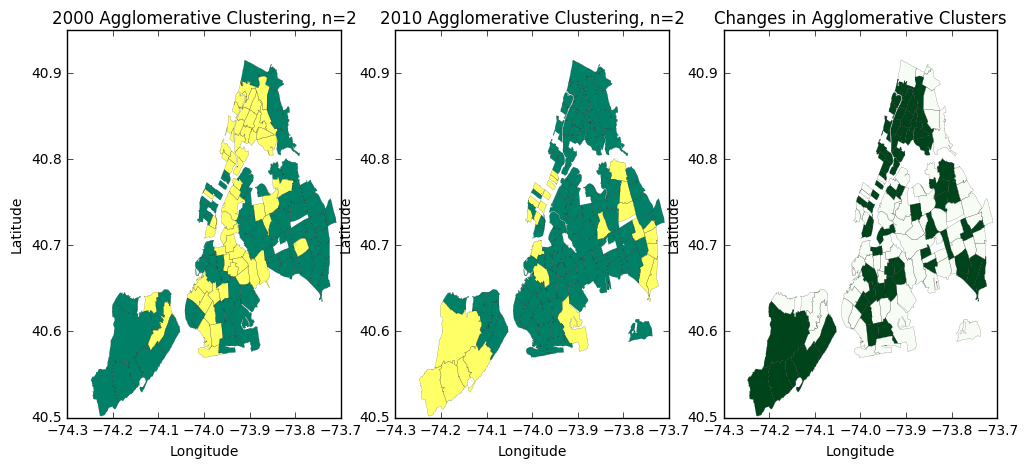

In [121]:
fig,ax = plt.subplots(figsize=(12,5))

ax1 = plt.subplot(131)
ax1.get_xaxis().set_visible(True)
ax1.get_yaxis().set_visible(True)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
W.plot(column='labelsag',cmap='summer',categorical = True, alpha=1,linewidth=0.1,ax = ax1)
plt.title("2000 Agglomerative Clustering, n=2")


ax2 = plt.subplot(132)
ax2.get_xaxis().set_visible(True)
ax2.get_yaxis().set_visible(True)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
Q.plot(column='labelsag',cmap='summer',categorical = True, alpha=1,linewidth=0.1,ax = ax2)
plt.title("2010 Agglomerative Clustering, n=2")


ax3 = plt.subplot(133)
ax3.get_xaxis().set_visible(True)
ax3.get_yaxis().set_visible(True)
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
clustering_test.plot(column ='compare2',cmap='Greens',categorical = True,alpha=1,linewidth=0.1,ax = ax3)
plt.title("Changes in Agglomerative Clusters")


12) Define a function that given a dataframe containing the relevant information and two cluster labels finds if the census tract changed cluster assignments from the first to the second label, and if so finds the individual features that are significantly different as measured by Pearson's correlation, plot those zip codes, and plot a histogram of the features that have significantly changed. Run your function for all label pairs (2 points, one for the identification of locations that changed cluster and one for the identifiation of the features that changed significantly).

### 13. Comment on the strength and weaknesses of this analysis, and on your findings (this is not the last step, but comments should be given throughout the notebook, and summarized here).

Strength of this analysis : Merging and using many data sources. Neat Visulaztions. Using two geographic information datasets to evaluate on the same events (age, income, diverity...). 

Weakness of this analysis : Failed to explain the exact changes in each figure and interperate what that might imply; Agglomerative Clustering seemed not works as it is supposed to be (in the light of plotting changes of cluters
are not completely consistent with the observations on both 'geo-id' and 'zip' level. There should be some errors occured. Also, in both geographic groupings, only two clusters are collected and either labled by '0' or '1'. However, the boolean outcome in df.['compare'] later were converted to '0' and '1' in df.['compare2'], which might affect the clustering to some extent; Missing vaules and invalid entries are unavoidable when dealing with the dataframe, which made the ploting not perfect.

Findings: Analysis based on the 'geo-id' level, the sensus tract shapefile offers much detialed information based on further divided regions on the map, if information is perfectly collected analysis based on that can present very rich informations about NYC. Analysis based on the 'zip' level, sometimes it's straightforward to gain an overall information about subject of interest, in terms of view the overall changes of cluters between 2000 and 2010, the zip case gives an easly idtentified result.

I did not finish the 12. since I am not good at defining a fuction.